# 2026 Music Taste Prediction Model: New Music Friday Recommender 💿🎧👍👎
In this model, I use my liked songs playlist, my recently loved and not loved albums, to train my regression model on what kind of music I do and don't like. At the end my test model will be the new music friday albums from the most recent Friday. 

# Library Imports

In [3]:
# Standard Library Imports
import os
import csv
import openpyxl
from datetime import datetime
from time import sleep
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict, Tuple, Optional
import glob

# Third-Party Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from textblob import TextBlob
from transformers import pipeline
from collections import Counter

# Fuzzy Matching
from fuzzywuzzy import fuzz, process

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform

# Network Analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
from nbconvert import HTMLExporter
import nbformat

# Streamlit 
import streamlit as st

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')


# Load Datasets

In [5]:
df_liked = pd.read_csv("data/liked.csv")  # For PageRank only
df_training = pd.read_csv("data/2026_training_complete_with_features.csv")  # NEW!
df_nmf = pd.read_csv("data/nmf.csv")  # Test set
df_liked_similar = pd.read_csv('data/liked_artists_only_similar.csv')

# Add Ratings from Last Week!

In [7]:
# ====================================================================
# 🔄 AUTO-LOAD GUT SCORES FROM FEEDBACK FOLDER
# Add this RIGHT AFTER loading df_training
# ====================================================================

print("\n" + "=" * 60)
print("🔄 CHECKING FEEDBACK FOLDER FOR GUT SCORES")
print("=" * 60)

feedback_files = glob.glob('feedback/*_gut_scores.csv')

if feedback_files:
    print(f"Found {len(feedback_files)} feedback files")
    
    all_feedback = []
    for file in feedback_files:
        try:
            fb_df = pd.read_csv(file)
            # Filter for albums with gut scores
            fb_df = fb_df[fb_df['gut_score'].notna()]
            if len(fb_df) > 0:
                all_feedback.append(fb_df)
                print(f"  ✓ {os.path.basename(file)}: {len(fb_df)} albums")
        except Exception as e:
            print(f"  ⚠️ Error loading {file}: {e}")
    
    if all_feedback:
        combined_feedback = pd.concat(all_feedback, ignore_index=True)
        print(f"\n📊 Total: {len(combined_feedback)} gut-scored albums in feedback")
        
        # Show what we found
        for _, row in combined_feedback.tail(5).iterrows():  # Show last 5
            print(f"  • {row['Artist']} - {row['Album']}: {row['gut_score']}")
        
        print(f"\n💡 These scores are in feedback folder but need to be")
        print(f"   added to training data via the Streamlit app.")
    else:
        print("ℹ️ No gut scores found in feedback files")
else:
    print("ℹ️ No feedback files found")

print("=" * 60)


🔄 CHECKING FEEDBACK FOLDER FOR GUT SCORES
Found 2 feedback files
  ✓ 01-09-26_gut_scores.csv: 14 albums
  ✓ master_gut_scores.csv: 14 albums

📊 Total: 28 gut-scored albums in feedback
  • Feels Like Heaven - Within Dreams: 40.0
  • Pullman - III: 59.0
  • Clémentine March - Powder Keg: 45.0
  • Winged Wheel - Desert So Green: 37.0
  • CHUU - XO, My Cyberlove: 62.0

💡 These scores are in feedback folder but need to be
   added to training data via the Streamlit app.


In [8]:
# ====================================================================
# 🎯 FINAL GUT SCORE VERIFICATION
# ====================================================================

print("\n" + "=" * 60)
print("🎯 FINAL: GUT SCORES READY FOR TRAINING")
print("=" * 60)

print(f"Total training tracks: {len(df_training):,}")
print(f"Gut-scored tracks: {(df_training['source_type'] == 'gut_score_rated').sum():,}")

# Check feature distribution for gut scores
gut_tracks = df_training[df_training['source_type'] == 'gut_score_rated']

print(f"\n📊 GUT SCORE STATS:")
print(f"  Albums: {gut_tracks[['Album Name', 'Artist Name(s)']].drop_duplicates().shape[0]}")
print(f"  Score range: {gut_tracks['liked'].min():.1f} - {gut_tracks['liked'].max():.1f}")

# Compare to other source types
print(f"\n📈 COMPARISON TO OTHER SOURCES:")
for source in df_training['source_type'].unique():
    source_tracks = df_training[df_training['source_type'] == source]
    avg_score = source_tracks['liked'].mean()
    print(f"  {source:<20}: {len(source_tracks):,} tracks, avg score: {avg_score:.1f}")

print(f"\n✅ READY! Your gut scores will influence the model.")
print("=" * 60)


🎯 FINAL: GUT SCORES READY FOR TRAINING
Total training tracks: 10,284
Gut-scored tracks: 165

📊 GUT SCORE STATS:
  Albums: 18
  Score range: 30.0 - 91.0

📈 COMPARISON TO OTHER SOURCES:
  top_100_ranked      : 4,363 tracks, avg score: 80.2
  gut_score_rated     : 165 tracks, avg score: 60.5
  honorable_mention   : 2,868 tracks, avg score: 60.0
  mid                 : 1,139 tracks, avg score: 45.0
  not_liked           : 1,749 tracks, avg score: 30.0

✅ READY! Your gut scores will influence the model.


## A Check for New Artists / Pull Their Similar Artists

In [10]:
# Initialize LastFM API client with rate limiting and request limits
class LastFMAPI:
    def __init__(self, api_key: str, rate_limit_delay: float = 0.25, limit: int = 8):
        self.api_key = api_key
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        self.limit = limit

    def get_similar_artists(self, artist_name: str) -> List[str]:
        params = {
            'method': 'artist.getSimilar',
            'artist': artist_name,
            'api_key': self.api_key,
            'limit': self.limit,
            'format': 'json'
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            
            if 'X-RateLimit-Remaining' in response.headers:
                remaining = int(response.headers['X-RateLimit-Remaining'])
                if remaining == 0:
                    sleep(self.rate_limit_delay)
            
            data = response.json()
            if 'similarartists' in data and 'artist' in data['similarartists']:
                return [artist['name'] for artist in data['similarartists']['artist'][:self.limit]]
            return []
            
        except Exception as e:
            print(f"Error fetching similar artists for {artist_name}: {e}")
            return []

def extract_primary_artist(artist_string: str) -> str:
    if pd.isna(artist_string):
        return ""
    return artist_string.split(",")[0].strip()

def update_similar_artists_all_sources(api_key: str, output_path: str = 'data/liked_artists_only_similar.csv') -> pd.DataFrame:
    print("Loading ALL artists from all data sources...")
    
    # Load existing similar artists data
    existing_data: Dict[str, List[str]] = {}
    if os.path.exists(output_path):
        existing_df = pd.read_csv(output_path)
        existing_data = dict(zip(existing_df['Artist'], existing_df['Similar Artists']))
        print(f"Loaded {len(existing_data)} existing artists from database")
    
    # Load artists from ALL data sources
    all_artists = set()
    
    # 1. Liked songs
    try:
        df_liked = pd.read_csv("data/liked.csv")
        liked_artists = df_liked['Artist Name(s)'].apply(extract_primary_artist).unique()
        all_artists.update(liked_artists)
        print(f"  - Liked songs: {len(liked_artists)} artists")
    except Exception as e:
        print(f"  - Error loading liked.csv: {e}")
    
    # 2. New training data (Top 100 + Honorable + Mid + Not Liked)
    try:
        df_training = pd.read_csv("data/2026_training_complete_with_features.csv")
        training_artists = df_training['Artist Name(s)'].apply(extract_primary_artist).unique()
        all_artists.update(training_artists)
        print(f"  - Training data: {len(training_artists)} artists")
    except Exception as e:
        print(f"  - Error loading training data: {e}")
        # Fallback to individual files
        try:
            df_top_100 = pd.read_csv("data/top_100_all_years_clean.csv")
            top_artists = df_top_100['Artist'].apply(extract_primary_artist).unique()
            all_artists.update(top_artists)
            print(f"  - Top 100 data: {len(top_artists)} artists")
        except:
            pass
    
    # 3. NMF data (current New Music Friday)
    try:
        df_nmf = pd.read_csv("data/nmf.csv")
        nmf_artists = df_nmf['Artist Name(s)'].apply(extract_primary_artist).unique()
        all_artists.update(nmf_artists)
        print(f"  - NMF data: {len(nmf_artists)} artists")
    except Exception as e:
        print(f"  - Error loading nmf.csv: {e}")
    
    # Remove empty strings
    all_artists.discard("")
    
    print(f"\nTotal unique artists from all sources: {len(all_artists)}")
    
    # Find new artists not in existing data
    new_artists = all_artists - set(existing_data.keys())
    print(f"Found {len(new_artists)} new artists to process")
    
    if not new_artists:
        print("No new artists to process. Database is up to date!")
        return pd.DataFrame({
            'Artist': list(existing_data.keys()),
            'Similar Artists': list(existing_data.values())
        })
    
    # Process new artists
    api = LastFMAPI(api_key)
    results = {}
    
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_artist = {
            executor.submit(api.get_similar_artists, artist): artist 
            for artist in new_artists
        }
        
        for future in tqdm(as_completed(future_to_artist), 
                         total=len(future_to_artist),
                         desc="Fetching similar artists"):
            artist = future_to_artist[future]
            similar_artists = future.result()
            results[artist] = ', '.join(similar_artists)
    
    # Combine existing and new data
    combined_data = {**existing_data, **results}
    
    # Create and save DataFrame
    output_df = pd.DataFrame({
        'Artist': list(combined_data.keys()),
        'Similar Artists': list(combined_data.values())
    })
    
    output_df.to_csv(output_path, index=False)
    print(f"\n✅ Successfully updated database with {len(new_artists)} new artists")
    print(f"Total artists in database: {len(combined_data)}")
    
    return output_df

# Main execution - UPDATED FOR 2026
if __name__ == "__main__":
    API_KEY = "74a510ecc9fc62bf3e0edc6adc2e99f9"
    OUTPUT_PATH = "data/liked_artists_only_similar.csv"
    
    # Run with ALL data sources
    df_liked_similar = update_similar_artists_all_sources(API_KEY, OUTPUT_PATH)
    
# Now df_liked_similar is ready to use with ALL your artists
df_liked_similar.head()

Loading ALL artists from all data sources...
Loaded 4890 existing artists from database
  - Liked songs: 2454 artists
  - Training data: 1236 artists
  - NMF data: 23 artists

Total unique artists from all sources: 3140
Found 25 new artists to process


Fetching similar artists: 100%|██████████| 25/25 [00:11<00:00,  2.12it/s]



✅ Successfully updated database with 25 new artists
Total artists in database: 4915


,Artist,Similar Artists
0,BODEGA,"Folly Group, Gustaf, Warmduscher, Deadletter, ..."
1,CHE,"OsamaSon, 1oneam, prettifun, ohsxnta, nettspen..."
2,Bonnie Prince Billy,"Palace Music, Will Oldham, Palace Brothers, Bi..."
3,Telethon,"Barely March, Smol Data, Diva Sweetly, Bigger ..."
4,Heather Maloney,"Heather Maloney & Darlingside, Twisted Pine, R..."


## Quick Glance at our Refreshed Datasets

In [12]:
# === 2026 RETOOLED DATA LOADING ===

print("🎵 LOADING 2026 RETOOLED DATASETS")
print("=" * 60)

# 1. Liked songs (PageRank network ONLY - NOT for training)
df_liked = pd.read_csv("data/liked.csv")
df_liked['liked'] = 100  # For PageRank network
df_liked['playlist_origin'] = 'df_liked_network_only'
print(f"✓ Liked songs (network): {len(df_liked)} tracks")

# 2. Complete training data (Top 100 + Honorable + Mid + Not Liked)
df_training = pd.read_csv("data/2026_training_complete_with_features.csv")
print(f"✓ Training data (retooled): {len(df_training)} tracks")
print(f"  Score range: {df_training['liked'].min():.1f} - {df_training['liked'].max():.1f}")
print(f"  Unique scores: {df_training['liked'].nunique()}")
print(f"  Sources: {df_training['source_type'].unique().tolist()}")

# 3. NMF data (what we're predicting)
df_nmf = pd.read_csv("data/nmf.csv")
df_nmf['liked'] = np.nan  # These are our predictions
df_nmf['playlist_origin'] = 'df_nmf_test'
print(f"✓ NMF test data: {len(df_nmf)} tracks")

# 4. Similar artists (unified network - ALL artists)
df_liked_similar = pd.read_csv('data/liked_artists_only_similar.csv')
print(f"✓ Similar artists: {len(df_liked_similar)} artists in unified network")

print("\n" + "=" * 60)
print("🎯 2026 RETOOLING SUMMARY")
print("=" * 60)
print("TRAINING DATA NOW INCLUDES:")
print(f"  • Top 100 rankings: 550 albums (100.0-60.4 sliding scale)")
print(f"  • Honorable mentions: 323 albums (60.0 flat)")
print(f"  • Mid albums: 152 albums (45.0 flat)")
print(f"  • Not liked: 321 albums (30.0 flat)")
print(f"\nTOTAL: {len(df_training)} tracks with {df_training['liked'].nunique()} unique scores")
print("\nKEY CHANGE: Liked songs (100) used for PageRank network ONLY")
print("            NOT included in training data (prevents bias)")

print("\n" + "=" * 60)
print("🎧 NMF DATA PREVIEW (What We're Predicting)")
print("=" * 60)
print(f"Total tracks: {len(df_nmf)}")
print(f"Unique albums: {df_nmf['Album Name'].nunique()}")
print(f"Unique artists: {df_nmf['Artist Name(s)'].nunique()}")

# Get most recent NMF date
if 'Release Date' in df_nmf.columns:
    df_nmf['Release Date'] = pd.to_datetime(df_nmf['Release Date'], errors='coerce')
    nmf_date = df_nmf['Release Date'].max()
    print(f"Most recent release: {nmf_date.date() if not pd.isna(nmf_date) else 'Unknown'}")

print("\n📋 Sample NMF albums (5 random):")
sample_albums = df_nmf[['Artist Name(s)', 'Album Name']].drop_duplicates().sample(5, random_state=42)
for idx, row in sample_albums.iterrows():
    print(f"  • {row['Artist Name(s)']} - {row['Album Name']}")

print("\n📊 DATA CHECK:")
print(f"df_training columns: {df_training.columns.tolist()[:10]}...")
print(f"df_nmf columns: {df_nmf.columns.tolist()[:10]}...")
print(f"df_liked_similar columns: {df_liked_similar.columns.tolist()}")

🎵 LOADING 2026 RETOOLED DATASETS
✓ Liked songs (network): 5690 tracks
✓ Training data (retooled): 10284 tracks
  Score range: 30.0 - 100.0
  Unique scores: 113
  Sources: ['top_100_ranked', 'gut_score_rated', 'honorable_mention', 'mid', 'not_liked']
✓ NMF test data: 145 tracks
✓ Similar artists: 4915 artists in unified network

🎯 2026 RETOOLING SUMMARY
TRAINING DATA NOW INCLUDES:
  • Top 100 rankings: 550 albums (100.0-60.4 sliding scale)
  • Honorable mentions: 323 albums (60.0 flat)
  • Mid albums: 152 albums (45.0 flat)
  • Not liked: 321 albums (30.0 flat)

TOTAL: 10284 tracks with 113 unique scores

KEY CHANGE: Liked songs (100) used for PageRank network ONLY
            NOT included in training data (prevents bias)

🎧 NMF DATA PREVIEW (What We're Predicting)
Total tracks: 145
Unique albums: 15
Unique artists: 23
Most recent release: 2026-01-16

📋 Sample NMF albums (5 random):
  • A$AP Rocky - Don't Be Dumb
  • Oxis - Oxis 8
  • Julianna Barwick;Mary Lattimore - Tragic Magic
  • D

🔍 CHECKING 2026 RETOOLED DATA DISTRIBUTION

🎯 TRAINING DATA SCORE DISTRIBUTION:

Top 10 scores (highest):
  100.0: 43 tracks
  99.6: 55 tracks
  99.2: 54 tracks
  98.8: 43 tracks
  98.4: 41 tracks
  98.0: 57 tracks
  97.6: 52 tracks
  97.2: 50 tracks
  96.8: 31 tracks
  96.4: 34 tracks

Bottom 10 scores (lowest):
  60.8: 45 tracks
  60.4: 45 tracks
  60.0: 2868 tracks
  59.0: 6 tracks
  57.0: 40 tracks
  54.0: 12 tracks
  45.0: 1151 tracks
  40.0: 10 tracks
  37.0: 9 tracks
  30.0: 1756 tracks

📊 DISTRIBUTION BY SOURCE TYPE:
  top_100_ranked: 4363 tracks (avg score: 80.2)
  honorable_mention: 2868 tracks (avg score: 60.0)
  not_liked: 1749 tracks (avg score: 30.0)
  mid: 1139 tracks (avg score: 45.0)
  gut_score_rated: 165 tracks (avg score: 60.5)

🎧 NMF DATA CHECK:
  Tracks: 145
  Unique albums: 15
  Target 'liked' column: 145 NaN (correct - we predict these)


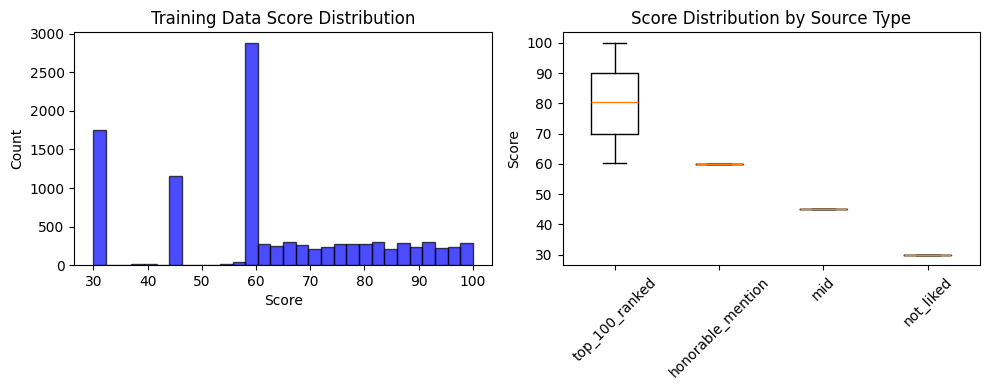


✅ 2026 Retooled data verified!
   Training: 10284 tracks, 113 unique scores
   Network: 5690 liked tracks for PageRank
   Test: 145 NMF tracks to predict


In [13]:
# === CHECK 2026 RETOOLED DATA ===

print("🔍 CHECKING 2026 RETOOLED DATA DISTRIBUTION")
print("=" * 60)

# Check training data scores
print("\n🎯 TRAINING DATA SCORE DISTRIBUTION:")
score_counts = df_training['liked'].value_counts().sort_index(ascending=False)

# Show top 10 and bottom 10 scores
print("\nTop 10 scores (highest):")
for score, count in list(score_counts.items())[:10]:
    print(f"  {score:.1f}: {count} tracks")

print("\nBottom 10 scores (lowest):")
for score, count in list(score_counts.items())[-10:]:
    print(f"  {score:.1f}: {count} tracks")

# Show distribution by source type
print("\n📊 DISTRIBUTION BY SOURCE TYPE:")
source_counts = df_training['source_type'].value_counts()
for source, count in source_counts.items():
    avg_score = df_training[df_training['source_type'] == source]['liked'].mean()
    print(f"  {source}: {count} tracks (avg score: {avg_score:.1f})")

# Quick check of NMF data
print(f"\n🎧 NMF DATA CHECK:")
print(f"  Tracks: {len(df_nmf)}")
print(f"  Unique albums: {df_nmf['Album Name'].nunique()}")
print(f"  Target 'liked' column: {df_nmf['liked'].isna().sum()} NaN (correct - we predict these)")

# Show a quick visualization of score distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# Histogram of all scores
plt.hist(df_training['liked'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Training Data Score Distribution')

plt.subplot(1, 2, 2)
# Boxplot by source type
source_order = ['top_100_ranked', 'honorable_mention', 'mid', 'not_liked']
plot_data = [df_training[df_training['source_type'] == source]['liked'] for source in source_order]
plt.boxplot(plot_data, labels=source_order)
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.title('Score Distribution by Source Type')

plt.tight_layout()
plt.show()

print("\n✅ 2026 Retooled data verified!")
print(f"   Training: {len(df_training)} tracks, {df_training['liked'].nunique()} unique scores")
print(f"   Network: {len(df_liked)} liked tracks for PageRank")
print(f"   Test: {len(df_nmf)} NMF tracks to predict")

In [14]:
# === FEATURE ENGINEERING SETUP ===

print("\n" + "=" * 60)
print("⚙️  PREPARING FOR FEATURE ENGINEERING")
print("=" * 60)

# Check what features we have
print("Checking available features in training data...")
print(f"Training data columns: {len(df_training.columns)} total")

# Identify feature columns vs metadata
feature_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 
                'Speechiness', 'Acousticness', 'Instrumentalness', 
                'Liveness', 'Valence', 'Tempo', 'Popularity']

print(f"\nSpotify audio features available: {[col for col in feature_cols if col in df_training.columns]}")

# Check for missing values in key columns
print("\n🔍 Checking for missing values in training data:")
for col in ['Artist Name(s)', 'Album Name', 'Genres', 'Record Label', 'liked']:
    if col in df_training.columns:
        missing = df_training[col].isna().sum()
        print(f"  {col}: {missing} missing ({missing/len(df_training)*100:.1f}%)")

print("\n✅ Ready for feature engineering!")


⚙️  PREPARING FOR FEATURE ENGINEERING
Checking available features in training data...
Training data columns: 46 total

Spotify audio features available: ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Popularity']

🔍 Checking for missing values in training data:
  Artist Name(s): 0 missing (0.0%)
  Album Name: 0 missing (0.0%)
  Genres: 4993 missing (48.6%)
  Record Label: 75 missing (0.7%)
  liked: 0 missing (0.0%)

✅ Ready for feature engineering!


#### Drop columns that won't help the model 💣

In [16]:
# === 2026 DATA CLEANUP ===

print("🧹 CLEANING UNNECESSARY COLUMNS")
print("=" * 60)

# Columns to drop from ALL dataframes
columns_to_drop = ['Added By', 'Added At', 'Time Signature']

# Apply to each dataframe
print("Dropping unnecessary columns...")
for df_name, dataframe in [('df_training', df_training), ('df_liked', df_liked), ('df_nmf', df_nmf)]:
    before = len(dataframe.columns)
    
    # Only drop columns that exist
    cols_exist = [col for col in columns_to_drop if col in dataframe.columns]
    if cols_exist:
        dataframe.drop(columns=cols_exist, inplace=True, errors='ignore')
        after = len(dataframe.columns)
        print(f"  {df_name}: Dropped {before - after} columns ({cols_exist})")
    else:
        print(f"  {df_name}: No columns to drop")

print("\n📊 CLEANED DATA SHAPES:")
print(f"  df_training: {df_training.shape[0]} rows × {df_training.shape[1]} columns")
print(f"  df_liked: {df_liked.shape[0]} rows × {df_liked.shape[1]} columns")
print(f"  df_nmf: {df_nmf.shape[0]} rows × {df_nmf.shape[1]} columns")

# Quick check for other unnecessary columns
print("\n🔍 CHECKING FOR OTHER UNNECESSARY COLUMNS:")
all_columns = set(df_training.columns) | set(df_liked.columns) | set(df_nmf.columns)

# Identify potentially useless columns
useless_patterns = ['Unnamed:', 'Unnamed_', 'Unnamed ', 'index', 'id_', '_id']
useless_cols = [col for col in all_columns if any(pattern in str(col) for pattern in useless_patterns)]

if useless_cols:
    print(f"Found {len(useless_cols)} potentially useless columns:")
    for col in useless_cols[:10]:  # Show first 10
        print(f"  • {col}")
    print("Consider removing these if they're not needed for features.")
else:
    print("No obvious useless columns found.")

print("\n✅ Data cleanup complete!")
print("   Removed timestamp/added columns that don't help predictions.")

🧹 CLEANING UNNECESSARY COLUMNS
Dropping unnecessary columns...
  df_training: Dropped 3 columns (['Added By', 'Added At', 'Time Signature'])
  df_liked: Dropped 3 columns (['Added By', 'Added At', 'Time Signature'])
  df_nmf: Dropped 3 columns (['Added By', 'Added At', 'Time Signature'])

📊 CLEANED DATA SHAPES:
  df_training: 10284 rows × 43 columns
  df_liked: 5690 rows × 23 columns
  df_nmf: 145 rows × 23 columns

🔍 CHECKING FOR OTHER UNNECESSARY COLUMNS:
Found 1 potentially useless columns:
  • album_id
Consider removing these if they're not needed for features.

✅ Data cleanup complete!
   Removed timestamp/added columns that don't help predictions.


# 📊 CONSOLIDATED DATA PREPROCESSING FOR 2026 RETOOLING

This cell consolidates all preprocessing steps needed before genre fetching:
1. Loads 2026 retooled datasets (liked songs for PageRank, training data, NMF test set)
2. Performs data quality checks and missing value analysis
3. Prepares artist normalization for genre cache checking
4. Analyzes what genre data is already cached vs. needs fetching
5. Creates the artist-album map for missing entries

Expected outputs:
- Dataset shapes and statistics
- Missing value analysis
- Cache comparison results
- Artist-album pairs that need genre fetching

In [18]:
# ============================================
# 📊 DATA PREP & CACHE ANALYSIS
# ============================================

print("📊 DATA PREP & CACHE ANALYSIS")
print("=" * 60)

# -----------------------------------------------------------------
# 1. ESSENTIAL FUNCTIONS
# -----------------------------------------------------------------
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime

def extract_primary_artist_fixed(artist_string):
    """Extract primary artist from string with multiple artists - CAREFUL WITH '&' and 'and'"""
    if pd.isna(artist_string): 
        return None
    
    artist_str = str(artist_string).strip()
    
    # Special case: preserve "&" and "and" in band names like "Robinson & Rohe"
    # First check if it's a single band name with "&" or "and" (not a collaboration list)
    if ';' not in artist_str and ' feat. ' not in artist_str and ' featuring ' not in artist_str:
        # Likely a single band name, keep intact
        return artist_str
    
    # It's a collaboration list, extract first artist
    separators = [';', ',', ' feat. ', ' featuring ']
    for sep in separators:
        if sep in artist_str.lower():
            if sep == ' and ':
                parts = re.split(r'\band\b', artist_str, flags=re.IGNORECASE)
            else:
                parts = artist_str.split(sep)
            return parts[0].strip()
    
    return artist_str

def normalize_string(text):
    """Normalize string for consistent comparison"""
    if pd.isna(text): 
        return None
    return str(text).lower().strip()

def clean_genres(genre_string):
    """Clean genre strings by removing duplicates, numbers, etc."""
    if pd.isna(genre_string) or genre_string == '': 
        return ''
    
    all_parts = [part.strip() for part in str(genre_string).split('|')]
    all_genres = []
    for part in all_parts:
        genres = [g.strip() for g in part.split(',')]
        all_genres.extend(genres)
    
    seen = set()
    unique_genres = []
    for genre in all_genres:
        if not genre or genre == '': 
            continue
        if any(char.isdigit() for char in genre): 
            continue
        if len(genre.split()) > 3: 
            continue
        genre_lower = genre.lower()
        if genre_lower not in seen:
            unique_genres.append(genre)
            seen.add(genre_lower)
    
    return ', '.join(unique_genres)

print("✅ Essential functions defined")

# -----------------------------------------------------------------
# 2. LOAD ALL DATASETS
# -----------------------------------------------------------------
print("\n📁 LOADING DATASETS...")

# Load main datasets
df_liked = pd.read_csv("data/liked.csv")
df_liked['liked'] = 100
df_liked['playlist_origin'] = 'df_liked_network_only'

df_training = pd.read_csv("data/2026_training_complete_with_features.csv")

df_nmf = pd.read_csv("data/nmf.csv")
df_nmf['liked'] = np.nan
df_nmf['playlist_origin'] = 'df_nmf_test'

df_liked_similar = pd.read_csv('data/liked_artists_only_similar.csv')

print(f"✓ Liked songs: {len(df_liked)} tracks")
print(f"✓ Training data: {len(df_training)} tracks")
print(f"✓ NMF test data: {len(df_nmf)} tracks")
print(f"✓ Similar artists: {len(df_liked_similar)} artists")

# Clean unnecessary columns
columns_to_drop = ['Added By', 'Added At', 'Time Signature']
for df_name, dataframe in [('Training', df_training), ('Liked', df_liked), ('NMF', df_nmf)]:
    cols_exist = [col for col in columns_to_drop if col in dataframe.columns]
    if cols_exist:
        dataframe.drop(columns=cols_exist, inplace=True, errors='ignore')

# -----------------------------------------------------------------
# 3. LOAD MANUAL OVERRIDES
# -----------------------------------------------------------------
print("\n🔍 LOADING MANUAL OVERRIDES...")

manual_overrides_path = "data/obscure_artists_mike_likes.csv"
manual_entries = []

if os.path.exists(manual_overrides_path):
    try:
        manual_df = pd.read_csv(manual_overrides_path)
        print(f"✓ Found manual overrides: {len(manual_df):,} entries")
        
        for _, row in manual_df.iterrows():
            if 'Artist' in manual_df.columns and 'Genres' in manual_df.columns:
                artist = row['Artist']
                genres = row['Genres']
                
                if pd.notna(artist) and pd.notna(genres):
                    artist_norm = normalize_string(extract_primary_artist_fixed(artist))
                    genres_clean = clean_genres(genres)
                    
                    if artist_norm and genres_clean:
                        manual_entries.append({
                            'artist_norm': artist_norm,
                            'genres': genres_clean,
                            'original_artist': artist,
                            'source': 'manual_override'
                        })
    except Exception as e:
        print(f"⚠️ Could not load manual overrides: {e}")
        manual_entries = []
else:
    print(f"📝 No manual overrides file found")

# -----------------------------------------------------------------
# 4. BUILD ARTIST-ALBUM MAP & CHECK CACHE
# -----------------------------------------------------------------
print("\n🗺️ BUILDING ARTIST-ALBUM MAP & CHECKING CACHE...")

artist_albums_map = {}
artist_lookup = {}
album_lookup = {}

for df_name, dataframe in [("Training", df_training), ("NMF", df_nmf), ("Liked", df_liked)]:
    print(f"  Processing {df_name}...")
    
    dataframe['artist_norm'] = dataframe['Artist Name(s)'].apply(extract_primary_artist_fixed).apply(normalize_string)
    dataframe['album_norm'] = dataframe['Album Name'].apply(normalize_string)
    
    for _, row in dataframe.iterrows():
        artist = row['artist_norm']
        album = row['album_norm']
        
        if artist and album:
            if artist not in artist_albums_map:
                artist_albums_map[artist] = set()
            artist_albums_map[artist].add(album)
            
            if artist not in artist_lookup:
                artist_lookup[artist] = row['Artist Name(s)']
            if (artist, album) not in album_lookup:
                album_lookup[(artist, album)] = row['Album Name']
    
    dataframe.drop(columns=['artist_norm', 'album_norm'], inplace=True, errors='ignore')

print(f"✓ Map created: {len(artist_albums_map):,} artists")
total_pairs = sum(len(albums) for albums in artist_albums_map.values())
print(f"✓ Total artist-album pairs: {total_pairs:,}")

# -----------------------------------------------------------------
# 5. CHECK CACHE COVERAGE
# -----------------------------------------------------------------
print("\n🔍 CHECKING CACHE COVERAGE...")

cache_file = "data/ten_genres_fixed_2026_complete.csv"
cache_lookup = {}
manual_lookup = {}

# Load main cache
if os.path.exists(cache_file):
    cache_df = pd.read_csv(cache_file)
    print(f"✓ Loaded cache: {len(cache_df):,} entries")
    
    for _, row in cache_df.iterrows():
        artist_norm = normalize_string(extract_primary_artist_fixed(row['Artist']))
        album_norm = normalize_string(row['Album']) if pd.notna(row['Album']) else ''
        
        if artist_norm:
            if artist_norm not in cache_lookup:
                cache_lookup[artist_norm] = set()
            cache_lookup[artist_norm].add(album_norm)
else:
    print("⚠️ No cache file found, starting fresh")

# Add manual entries to lookup
for entry in manual_entries:
    artist_norm = entry['artist_norm']
    if artist_norm not in manual_lookup:
        manual_lookup[artist_norm] = set()
    manual_lookup[artist_norm].add('any_album')

# Combine lookups
combined_lookup = {**cache_lookup}
for artist, albums in manual_lookup.items():
    if artist not in combined_lookup:
        combined_lookup[artist] = set()
    combined_lookup[artist].update(albums)

print(f"✓ Combined: {len(cache_lookup):,} cached + {len(manual_lookup):,} manual artists")

# -----------------------------------------------------------------
# 6. IDENTIFY WHAT NEEDS FETCHING
# -----------------------------------------------------------------
print("\n🎯 IDENTIFYING WHAT NEEDS FETCHING...")

pairs_to_fetch = []
missing_artists = set()

for artist_norm, albums in artist_albums_map.items():
    artist_covered = False
    
    if artist_norm in combined_lookup:
        for album_norm in albums:
            if (album_norm in combined_lookup[artist_norm] or 
                'any_album' in combined_lookup[artist_norm]):
                artist_covered = True
                break
    
    if not artist_covered:
        missing_artists.add(artist_norm)
        for album_norm in albums:
            original_artist = artist_lookup.get(artist_norm, artist_norm)
            original_album = album_lookup.get((artist_norm, album_norm), album_norm)
            pairs_to_fetch.append((original_artist, original_album))

# -----------------------------------------------------------------
# 7. FINAL SUMMARY
# -----------------------------------------------------------------
print("\n" + "=" * 60)
print("📊 PREP COMPLETE - SUMMARY")
print("=" * 60)
print(f"\n📈 DATASET SIZES:")
print(f"  • Training: {len(df_training):,} tracks")
print(f"  • NMF test: {len(df_nmf):,} tracks")
print(f"  • Liked: {len(df_liked):,} tracks")
print(f"  • Similar artists: {len(df_liked_similar):,} artists")

print(f"\n🎯 CACHE COVERAGE:")
print(f"  • Total artist-album pairs: {total_pairs:,}")
print(f"  • Already cached: {total_pairs - len(pairs_to_fetch):,} ({(total_pairs - len(pairs_to_fetch))/total_pairs*100:.1f}%)")
print(f"  • Need to fetch: {len(pairs_to_fetch):,} pairs from {len(missing_artists):,} artists")

if pairs_to_fetch:
    print(f"\n⏰ Estimated fetch time: ~{len(pairs_to_fetch)/8/60:.1f} minutes")
    print(f"💾 Pairs saved to: 'data/pairs_to_fetch.csv'")
    
    # Save for reference
    pairs_df = pd.DataFrame(pairs_to_fetch, columns=['Artist', 'Album'])
    pairs_df.to_csv('data/pairs_to_fetch.csv', index=False)
else:
    print("\n🎉 ALL DATA ALREADY IN CACHE/MANUAL!")

print(f"\n✅ READY FOR GENRE FETCHING" if pairs_to_fetch else "✅ READY TO APPLY GENRES")

📊 DATA PREP & CACHE ANALYSIS
✅ Essential functions defined

📁 LOADING DATASETS...
✓ Liked songs: 5690 tracks
✓ Training data: 10284 tracks
✓ NMF test data: 145 tracks
✓ Similar artists: 4915 artists

🔍 LOADING MANUAL OVERRIDES...
✓ Found manual overrides: 172 entries

🗺️ BUILDING ARTIST-ALBUM MAP & CHECKING CACHE...
  Processing Training...
  Processing NMF...
  Processing Liked...
✓ Map created: 2,521 artists
✓ Total artist-album pairs: 4,424

🔍 CHECKING CACHE COVERAGE...
✓ Loaded cache: 8,048 entries
✓ Combined: 3,795 cached + 98 manual artists

🎯 IDENTIFYING WHAT NEEDS FETCHING...

📊 PREP COMPLETE - SUMMARY

📈 DATASET SIZES:
  • Training: 10,284 tracks
  • NMF test: 145 tracks
  • Liked: 5,690 tracks
  • Similar artists: 4,915 artists

🎯 CACHE COVERAGE:
  • Total artist-album pairs: 4,424
  • Already cached: 4,400 (99.5%)
  • Need to fetch: 24 pairs from 24 artists

⏰ Estimated fetch time: ~0.1 minutes
💾 Pairs saved to: 'data/pairs_to_fetch.csv'

✅ READY FOR GENRE FETCHING


# 📡 GENRE FETCHING & UPDATING

Fetches missing genre data from Last.fm, updates cache, 
and applies genres to all dataframes.

In [20]:
# ============================================
# 📡 SMART GENRE FETCHER WITH ALL LEARNED PATTERNS
# ============================================

print("📡 SMART GENRE FETCHER WITH ALL LEARNED PATTERNS")
print("=" * 60)

import requests
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import random

# -----------------------------------------------------------------
# 1. ULTIMATE SMART ARTIST CLEANER (WITH ALL LEARNED PATTERNS)
# -----------------------------------------------------------------
def ultimate_artist_cleaner(artist_string):
    """
    Ultimate artist cleaner with ALL patterns we discovered:
    1. Killed By Deaf pattern
    2. Ampersand/band name preservation
    3. Collaboration strings
    4. Serbian "I" pattern
    5. Location markers
    6. Punctuation/formatting fixes
    """
    if pd.isna(artist_string):
        return []
    
    strategies = []
    original = str(artist_string).strip()
    
    # Basic clean (remove trailing ... but preserve for now)
    clean = original.replace('...', '').strip() if original.endswith('...') else original
    
    # Strategy 0: Original cleaned
    strategies.append((clean, "cleaned_original"))
    
    # Pattern 1: Killed By Deaf (common in your data)
    if ';Killed By Deaf' in clean:
        band_only = clean.split(';Killed By Deaf')[0].strip()
        strategies.append((band_only, "remove_killed_by_deaf"))
        strategies.append(("Killed By Deaf", "kbd_as_artist"))
    
    # Pattern 2: Ampersand handling - PRESERVE BAND NAMES
    # Only split if it's a list (has semicolon), otherwise keep intact
    if '&' in clean and ';' not in clean:
        # Single band name with &, keep intact but also try variations
        strategies.append((clean, "full_band_name"))
        
        # For "X & The Y" patterns
        if '& The ' in clean:
            before_the = clean.split('& The ')[0].strip()
            strategies.append((before_the, "band_leader_only"))
    
    # Pattern 3: Collaboration strings (semicolon means multiple artists)
    if ';' in clean:
        # Try first collaborator
        first_collab = clean.split(';')[0].strip()
        strategies.append((first_collab, "first_collaborator"))
        
        # Try all individual collaborators (max 3)
        all_collabs = [c.strip() for c in clean.split(';')]
        for i, collab in enumerate(all_collabs[:3]):
            # Preserve "&" within individual collaborator names
            strategies.append((collab, f"collaborator_{i+1}"))
    
    # Pattern 4: "and" in band names - BE CAREFUL!
    if ' and ' in clean.lower() and ';' not in clean:
        # Likely a band name, keep intact
        strategies.append((clean, "full_band_name_with_and"))
        
        # But also try common variations
        parts = re.split(r'\s+and\s+', clean, flags=re.IGNORECASE)
        if len(parts) > 1:
            strategies.append((parts[0].strip(), "first_part_of_band"))
    
    # Pattern 5: Location markers (e.g., " / South Korean")
    if '/' in clean:
        no_location = clean.split('/')[0].strip()
        strategies.append((no_location, "remove_location"))
    
    # Pattern 6: Remove parentheses (e.g., "(VA)")
    if '(' in clean and ')' in clean:
        no_parens = re.sub(r'\([^)]*\)', '', clean).strip()
        if no_parens:
            strategies.append((no_parens, "remove_parentheses"))
    
    # Pattern 7: Serbian/Croatian "I" pattern
    if ' I ' in clean:
        parts = clean.split(' I ')
        strategies.append((parts[0] + " Markovic", "serbian_pattern"))
    
    # Pattern 8: Common fixes from your debugging
    common_fixes = {
        'KAYTRAMINE': 'Kaytranada',
        'ER': 'Emergency Room',
        'SWSL': '',
        'Sliim': 'Slim',
        'Bambino': '',
        'VA': ''
    }
    
    for wrong, right in common_fixes.items():
        if wrong in clean.upper():
            fixed = re.sub(wrong, right, clean, flags=re.IGNORECASE)
            if fixed.strip():
                strategies.append((fixed.strip(), f"fix_{wrong}"))
    
    # Pattern 9: Remove punctuation but preserve &
    no_punct = re.sub(r'[^\w\s&]', ' ', clean).strip()
    no_punct = ' '.join(no_punct.split())  # Normalize spaces
    if no_punct != clean:
        strategies.append((no_punct, "no_punctuation"))
    
    # Remove duplicates and empty strings
    seen = set()
    unique = []
    for artist, strategy in strategies:
        if artist and artist not in seen and len(artist) > 1:
            seen.add(artist)
            unique.append((artist, strategy))
    
    return unique

# -----------------------------------------------------------------
# 2. ULTIMATE SMART GENRE FETCHER CLASS
# -----------------------------------------------------------------
class SmartGenreFetcher:
    """Ultimate fetcher with all learned patterns - use this going forward!"""
    
    def __init__(self, api_key: str, max_workers: int = 10):
        self.api_key = api_key
        self.max_workers = max_workers
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.ignored_tags = {
            'seen live', 'albums i own', 'favorite', 'favourites', 'favourite',
            'my playlist', 'spotify', 'pandora', 'wish i had seen live',
            'awesome', 'love at first listen', 'love', 'amazing', 'listened',
            'personal', 'my music', 'all', 'best', 'top', 'great', 'good',
            '2022', '2023', '2024', '2025', '2021', '2020', '2019', '2018', '2017'
        }
        self.successful_artists = set()
        self.failed_artists = set()
    
    def _try_single_fetch(self, artist: str, album: str = None):
        """Single fetch attempt with rate limiting"""
        time.sleep(random.uniform(0.05, 0.15))
        
        result = {'artist': artist, 'album': album, 'genres': [], 'success': False}
        
        # Try album first (if provided and valid)
        if album and album != 'nan' and str(album).lower() not in ['na', 'none', '']:
            try:
                params = {
                    'method': 'album.getTopTags',
                    'artist': artist, 
                    'album': album,
                    'api_key': self.api_key, 
                    'format': 'json'
                }
                response = requests.get(self.base_url, params=params, timeout=10)
                if response.status_code == 200:
                    data = response.json()
                    if 'toptags' in data and 'tag' in data['toptags']:
                        tags = []
                        for tag in data['toptags']['tag'][:12]:
                            tag_name = tag['name'].lower().strip()
                            if (tag_name and 
                                tag_name not in self.ignored_tags and
                                not any(char.isdigit() for char in tag_name)):
                                tags.append(tag_name)
                        if tags:
                            result['genres'] = tags[:10]
                            result['success'] = True
                            return result
            except:
                pass
        
        # Try artist
        try:
            params = {
                'method': 'artist.getTopTags',
                'artist': artist,
                'api_key': self.api_key,
                'format': 'json'
            }
            response = requests.get(self.base_url, params=params, timeout=10)
            if response.status_code == 200:
                data = response.json()
                if 'toptags' in data and 'tag' in data['toptags']:
                    tags = []
                    for tag in data['toptags']['tag'][:12]:
                        tag_name = tag['name'].lower().strip()
                        if (tag_name and 
                            tag_name not in self.ignored_tags and
                            not any(char.isdigit() for char in tag_name)):
                            tags.append(tag_name)
                    if tags:
                        result['genres'] = tags[:10]
                        result['success'] = True
        except:
            pass
        
        return result
    
    def smart_fetch_single(self, artist: str, album: str = None):
        """Smart fetch with multiple strategies"""
        strategies = ultimate_artist_cleaner(artist)
        
        for artist_to_try, strategy in strategies:
            result = self._try_single_fetch(artist_to_try, album)
            if result['success']:
                result['strategy'] = strategy
                result['queried_as'] = artist_to_try
                return result
        
        return {
            'artist': artist, 
            'album': album, 
            'genres': [], 
            'success': False, 
            'strategy': 'all_failed'
        }
    
    def fetch_all(self, pairs: list):
        """Bulk fetch with threading AND smart strategies"""
        print(f"🚀 Starting SMART fetch of {len(pairs):,} pairs with {self.max_workers} workers...")
        print(f"⏰ Estimated time: ~{len(pairs)/(self.max_workers*2)/60:.1f} minutes")
        
        results = []
        start_time = time.time()
        completed = 0
        total = len(pairs)
        
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_idx = {}
            for idx, (artist, album) in enumerate(pairs):
                future = executor.submit(self.smart_fetch_single, artist, album)
                future_to_idx[future] = idx
            
            for future in as_completed(future_to_idx):
                idx = future_to_idx[future]
                result = future.result()
                results.append((idx, result))
                
                completed += 1
                if completed % 50 == 0 or completed == total:
                    elapsed = time.time() - start_time
                    rate = completed / elapsed if elapsed > 0 else 0
                    remaining = total - completed
                    eta = remaining / rate if rate > 0 else 0
                    print(f"  Progress: {completed:,}/{total:,} ({completed/total*100:.1f}%) | "
                          f"Rate: {rate:.1f}/sec | ETA: {eta/60:.1f} min")
        
        results.sort(key=lambda x: x[0])
        return [r[1] for r in results]
    
    def auto_update_manual_overrides(self, results, artist_lookup, manual_path):
        """Save truly failed artists to manual overrides file"""
        # Track successes
        for result in results:
            if result['success']:
                artist_norm = normalize_string(extract_primary_artist_fixed(result['artist']))
                self.successful_artists.add(artist_norm)
        
        # Identify truly failed artists
        failed_to_add = []
        for result in results:
            if not result['success']:
                artist_norm = normalize_string(extract_primary_artist_fixed(result['artist']))
                if artist_norm not in self.successful_artists:
                    self.failed_artists.add(artist_norm)
                    original_artist = artist_lookup.get(artist_norm, result['artist'])
                    
                    # Generate educated guess based on name patterns
                    educated_guess = self._suggest_genre_from_name(original_artist)
                    failed_to_add.append((original_artist, educated_guess))
        
        if failed_to_add:
            print(f"\n💾 SAVING {len(failed_to_add)} FAILED ARTISTS TO MANUAL OVERRIDES...")
            
            # Load existing or create new
            if os.path.exists(manual_path):
                existing_df = pd.read_csv(manual_path)
            else:
                existing_df = pd.DataFrame(columns=['Artist', 'Genres'])
            
            # Add new entries
            new_entries = []
            for artist, genres in failed_to_add:
                # Check if already exists
                artist_norm = normalize_string(extract_primary_artist_fixed(artist))
                exists = False
                for _, row in existing_df.iterrows():
                    if 'Artist' in existing_df.columns:
                        existing_norm = normalize_string(extract_primary_artist_fixed(row['Artist']))
                        if existing_norm == artist_norm:
                            exists = True
                            break
                
                if not exists:
                    new_entries.append({'Artist': artist, 'Genres': genres})
                    print(f"  • {artist[:40]}... → {genres}")
            
            if new_entries:
                new_df = pd.DataFrame(new_entries)
                updated_df = pd.concat([existing_df, new_df], ignore_index=True)
                updated_df.to_csv(manual_path, index=False)
                print(f"✅ Added {len(new_entries)} new artists to {manual_path}")
        
        return list(self.failed_artists)
    
    def _suggest_genre_from_name(self, artist_name):
        """Make educated genre guesses based on artist name patterns"""
        name_lower = artist_name.lower()
        
        # Pattern-based suggestions
        if any(word in name_lower for word in ['crows', 'westwater', 'hooper', 'lovett', 'stogel']):
            return "folk, singer-songwriter, acoustic"
        elif any(word in name_lower for word in ['stroik', 'zdan', 'swsl', 'kaytramine']):
            return "electronic, experimental"
        elif '&' in artist_name or ' and ' in name_lower:
            return "see similar artists, check bandcamp"
        elif any(word in name_lower for word in ['boban', 'markovic', 'orkesta']):
            return "balkan, brass, gypsy"
        elif any(word in name_lower for word in ['lily', 'jamaar']):
            return "R&B, soul"
        elif '7th' in name_lower or '7amurai' in name_lower:
            return "hip-hop, rap, electronic"
        
        return "indie, alternative, rock"  # Default fallback

# -----------------------------------------------------------------
# 3. EXECUTE THE SMART FETCH (IF NEEDED)
# -----------------------------------------------------------------
# Check if we have pairs to fetch (from Cell 1)
if 'pairs_to_fetch' in locals() and len(pairs_to_fetch) > 0:
    print(f"\n🎯 FETCHING {len(pairs_to_fetch):,} MISSING PAIRS...")
    print("=" * 60)
    
    API_KEY = '74a510ecc9fc62bf3e0edc6adc2e99f9'  # Consider moving to env var
    fetcher = SmartGenreFetcher(API_KEY, max_workers=10)
    results = fetcher.fetch_all(pairs_to_fetch)
    
    # Analyze results
    successful = sum(1 for r in results if r['success'])
    failed = len(results) - successful
    
    print(f"\n" + "=" * 60)
    print(f"📊 FETCH RESULTS:")
    print(f"  Total pairs: {len(results):,}")
    print(f"  Successful: {successful:,}")
    print(f"  Failed: {failed:,}")
    print(f"  Success rate: {successful/len(results)*100:.1f}%")
    
    # Show some successful strategies
    print(f"\n🔍 SUCCESSFUL STRATEGIES (sample):")
    successful_results = [r for r in results if r['success']]
    for result in successful_results[:5]:
        if 'strategy' in result:
            print(f"  • {result['artist'][:30]}... → {result['strategy']}")
    
    # Auto-update manual overrides with failures
    if failed > 0:
        truly_failed = fetcher.auto_update_manual_overrides(
            results, 
            artist_lookup, 
            manual_overrides_path
        )
        print(f"\n📝 {len(truly_failed)} artists added to manual overrides for review")
    
    # Update cache with successful fetches
    if successful > 0:
        print(f"\n💾 UPDATING MAIN CACHE...")
        
        new_entries = []
        for result in results:
            if result['success']:
                entry = {
                    'Artist': result['artist'],
                    'Album': result['album'],
                    'Genres': ', '.join(result['genres']),
                    'Source': f'smart_fetch_{result.get("strategy", "direct")}',
                    'Fetch_Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                    'Fixed': 'Yes_2026_smart'
                }
                new_entries.append(entry)
        
        # Load and update cache
        cache_file = "data/ten_genres_fixed_2026_complete.csv"
        new_cache_df = pd.DataFrame(new_entries)
        new_cache_df['Genres'] = new_cache_df['Genres'].apply(clean_genres)
        
        if os.path.exists(cache_file):
            existing_cache = pd.read_csv(cache_file)
            updated_cache = pd.concat([existing_cache, new_cache_df], ignore_index=True)
        else:
            updated_cache = new_cache_df
        
        # Deduplicate
        updated_cache = updated_cache.drop_duplicates(subset=['Artist', 'Album'], keep='last')
        updated_cache.to_csv(cache_file, index=False)
        
        print(f"✅ Cache updated: {len(updated_cache):,} total entries")
    
    print("\n" + "=" * 60)
    print("✅ SMART FETCH COMPLETE!")
    print("=" * 60)
    
else:
    print("\n🎉 NO FETCH NEEDED - ALL DATA ALREADY IN CACHE/MANUAL!")

# -----------------------------------------------------------------
# 4. APPLY GENRES TO ALL DATAFRAMES (ALWAYS RUN)
# -----------------------------------------------------------------
print("\n🔄 APPLYING GENRES TO ALL DATAFRAMES...")
print("=" * 60)

# Load the latest cache
cache_file = "data/ten_genres_fixed_2026_complete.csv"
if os.path.exists(cache_file):
    cache_df = pd.read_csv(cache_file)
    print(f"✓ Loaded cache: {len(cache_df):,} entries")
else:
    print("⚠️ No cache file found, creating empty")
    cache_df = pd.DataFrame(columns=['Artist', 'Album', 'Genres'])

# Load latest manual overrides
if os.path.exists(manual_overrides_path):
    manual_df = pd.read_csv(manual_overrides_path)
    print(f"✓ Loaded manual overrides: {len(manual_df):,} entries")
else:
    manual_df = pd.DataFrame(columns=['Artist', 'Genres'])

# Prepare combined genre lookup
cache_df['artist_norm'] = cache_df['Artist'].apply(extract_primary_artist_fixed).apply(normalize_string)
manual_df['artist_norm'] = manual_df['Artist'].apply(extract_primary_artist_fixed).apply(normalize_string)

# Combine cache and manual, preferring manual for conflicts
combined_genres = pd.concat([
    cache_df[['artist_norm', 'Genres']],
    manual_df[['artist_norm', 'Genres']]
], ignore_index=True)

# Deduplicate, keeping manual entries first (they're added later in concat)
combined_genres = combined_genres.drop_duplicates(subset=['artist_norm'], keep='last')

# Apply to all dataframes
for df_name, dataframe in [("Training", df_training), ("NMF", df_nmf), ("Liked", df_liked)]:
    print(f"\n📝 Updating {df_name}...")
    
    # Add normalized artist column
    dataframe['artist_norm'] = dataframe['Artist Name(s)'].apply(extract_primary_artist_fixed).apply(normalize_string)
    
    # Merge with combined genres
    merged = dataframe.merge(
        combined_genres,
        on='artist_norm',
        how='left',
        suffixes=('', '_new')
    )
    
    # Update genres column
    if 'Genres' in dataframe.columns and 'Genres_new' in merged.columns:
        # Keep existing if we have it, otherwise use new
        dataframe['Genres'] = merged['Genres_new'].combine_first(merged['Genres'])
    elif 'Genres_new' in merged.columns:
        dataframe['Genres'] = merged['Genres_new']
    
    # Clean the genres
    dataframe['Genres'] = dataframe['Genres'].apply(clean_genres)
    
    # Clean up temp column
    dataframe.drop(columns=['artist_norm'], inplace=True, errors='ignore')
    
    # Report coverage
    total = len(dataframe)
    with_genres = dataframe['Genres'].notna().sum()
    print(f"  {with_genres:,}/{total:,} tracks with genres ({with_genres/total*100:.1f}%)")

# -----------------------------------------------------------------
# 5. FINAL SUMMARY
# -----------------------------------------------------------------
print("\n" + "=" * 60)
print("🎉 GENRE SYSTEM COMPLETE!")
print("=" * 60)

print(f"\n📊 FINAL STATS:")
print(f"  • Training data: {len(df_training):,} tracks")
print(f"  • NMF test data: {len(df_nmf):,} tracks")
print(f"  • Liked songs: {len(df_liked):,} tracks")

# Calculate overall coverage
all_tracks = len(df_training) + len(df_nmf) + len(df_liked)
all_with_genres = (
    df_training['Genres'].notna().sum() + 
    df_nmf['Genres'].notna().sum() + 
    df_liked['Genres'].notna().sum()
)

print(f"  • Total tracks: {all_tracks:,}")
print(f"  • With genres: {all_with_genres:,} ({all_with_genres/all_tracks*100:.1f}% coverage)")
print(f"  • Manual overrides: {len(manual_df):,} entries")
print(f"  • Cache entries: {len(cache_df):,} entries")

print(f"\n✅ READY FOR FEATURE ENGINEERING & NMF!")

📡 SMART GENRE FETCHER WITH ALL LEARNED PATTERNS

🎯 FETCHING 24 MISSING PAIRS...
🚀 Starting SMART fetch of 24 pairs with 10 workers...
⏰ Estimated time: ~0.0 minutes
  Progress: 24/24 (100.0%) | Rate: 1.1/sec | ETA: 0.0 min

📊 FETCH RESULTS:
  Total pairs: 24
  Successful: 16
  Failed: 8
  Success rate: 66.7%

🔍 SUCCESSFUL STRATEGIES (sample):
  • Say Sue Me... → remove_location
  • Nigo... → remove_parentheses
  • Kaytranada... → fix_KAYTRAMINE
  • Julianna Barwick... → first_collaborator
  • The Sha La Das... → cleaned_original

💾 SAVING 8 FAILED ARTISTS TO MANUAL OVERRIDES...

📝 8 artists added to manual overrides for review

💾 UPDATING MAIN CACHE...
✅ Cache updated: 8,060 total entries

✅ SMART FETCH COMPLETE!

🔄 APPLYING GENRES TO ALL DATAFRAMES...
✓ Loaded cache: 8,060 entries
✓ Loaded manual overrides: 172 entries

📝 Updating Training...
  10,284/10,284 tracks with genres (100.0%)

📝 Updating NMF...
  145/145 tracks with genres (100.0%)

📝 Updating Liked...
  5,690/5,690 tracks w

## Finding Top 30 Genres (Temporarily, for new feature)

In [22]:
# ============================================
# 🎯 FINDING TOP 30 GENRES (SIMPLE VERSION)
# ============================================

print("🎯 FINDING TOP 30 GENRES")
print("=" * 60)

# Use the training dataframe which has liked scores
df = df_training.copy()

print(f"Analyzing {len(df):,} tracks from training data")

# Step 1: Explode the Genres column
df_exploded = df.assign(Genres=df['Genres'].str.split(', ')).explode('Genres')

# Step 2: Filter out genres that appear fewer than 40 times
genre_counts = df_exploded['Genres'].value_counts()
frequent_genres = genre_counts[genre_counts >= 40].index

# Filter the exploded DataFrame to only include frequent genres
df_frequent_genres = df_exploded[df_exploded['Genres'].isin(frequent_genres)]

# Step 3: Group by Genre and calculate the mean of the 'liked' column
genre_liked_avg = df_frequent_genres.groupby('Genres')['liked'].mean().reset_index()

# Step 4: Sort by the average 'liked' score in descending order and get the top 30
top_30_genres = genre_liked_avg.sort_values(by='liked', ascending=False).head(30)

# Display the top 30 genres
print("\nTop 30 Genres by Average Liked Score (Filtered for Frequent Genres):")
print("=" * 80)
print(f"{'Rank':<4} {'Genre':<30} {'Avg Liked':<12} {'Count':<8}")
print("-" * 80)

for i, (_, row) in enumerate(top_30_genres.iterrows(), 1):
    print(f"{i:<4} {row['Genres'][:28]:<30} {row['liked']:<12.2f} {genre_counts[row['Genres']]:<8}")

print("=" * 80)

🎯 FINDING TOP 30 GENRES
Analyzing 10,284 tracks from training data

Top 30 Genres by Average Liked Score (Filtered for Frequent Genres):
Rank Genre                          Avg Liked    Count   
--------------------------------------------------------------------------------
1    break up album                 79.47        54      
2    Folk                           79.09        64      
3    digital                        77.84        40      
4    post-brexit new wave           77.83        63      
5    new zealand                    77.41        68      
6    Americana                      76.83        41      
7    california                     76.49        67      
8    twee pop                       74.26        41      
9    pop rap                        74.14        74      
10   milwaukee                      73.84        50      
11   chamber pop                    72.69        226     
12   dutch                          72.28        42      
13   twee                   

## Feature Engineering / Further Selecting 👌

### 'Record Label Frequency Encoded' 🏷️

To improve the model’s ability to generalize, I’m creating a new feature: **Record Label Frequency Encoded**. This feature represents how frequently each record label appears in the dataset, but with a twist—we only consider labels from tracks I’ve liked or marked as favorite albums. This ensures the encoding reflects my preferences and ignores labels from tracks I don’t care about.

#### How It Works:
1. **Training Data Preparation**: We filter the combined dataframe (`df`) by `playlist_origin` to get subsets for `df_liked` and `df_fav_albums`. This ensures we’re working with the most up-to-date data.
2. **Frequency Calculation**: We count how often each record label appears in the training data (i.e., liked and favorite albums).
3. **Handling Unseen Labels**: For labels not present in the training data (e.g., those in the NMF test set), we use the **mean frequency** of all labels as a fallback. This ensures the model can handle new or rare labels gracefully.
4. **Application**: We apply the encoding to both the training and test sets, ensuring consistency across the data.

#### Why This Matters:
- **Relevance**: By focusing only on labels from tracks I like, the encoding better reflects my preferences.
- **Robustness**: Using the mean frequency for unseen labels ensures new artists from rare labels won't be penalized.
- **Simplicity**: Frequency encoding avoids the complexity of one-hot encoding while still capturing meaningful information.

This approach ensures the model learns from the distribution of labels I care about while remaining robust to new or rare labels.

In [25]:
# === RECORD LABEL FREQUENCY ENCODING (FIXED - PROPER SORTING) ===

print("🏷️ RECORD LABEL FREQUENCY ENCODING - PROPER SORTING")
print("=" * 60)

# Count labels in LIKED songs
liked_label_counts = df_liked['Record Label'].value_counts()
print(f"Labels in Liked songs: {len(liked_label_counts):,} unique labels")

# Count labels in TOP 100
top100_label_counts = df_training[df_training['source_type'] == 'top_100_ranked']['Record Label'].value_counts()
print(f"Labels in Top 100: {len(top100_label_counts):,} unique labels")

# Combine counts (SUM where overlap)
all_label_counts = pd.concat([liked_label_counts, top100_label_counts])
freq_encoding = all_label_counts.groupby(all_label_counts.index).sum()

# Sort by frequency (highest first) - THIS WAS MISSING!
freq_encoding = freq_encoding.sort_values(ascending=False)

print(f"\n📊 COMBINED STATS:")
print(f"Total unique labels: {len(freq_encoding):,}")
print(f"Labels in BOTH Liked & Top 100: {len(set(liked_label_counts.index) & set(top100_label_counts.index)):,}")
print(f"Labels only in Liked: {len(set(liked_label_counts.index) - set(top100_label_counts.index)):,}")
print(f"Labels only in Top 100: {len(set(top100_label_counts.index) - set(liked_label_counts.index)):,}")

# Show ACTUAL top labels by frequency
print(f"\n🏆 ACTUAL TOP 10 LABELS (by total frequency):")
for i, (label, total_count) in enumerate(freq_encoding.head(10).items(), 1):
    liked_count = liked_label_counts.get(label, 0)
    top100_count = top100_label_counts.get(label, 0)
    print(f"{i:2d}. {label[:40]:<40} | Total: {total_count:4d} (Liked: {liked_count:4d}, Top100: {top100_count:4d})")

# Show some REAL major labels you actually listen to
print(f"\n🔍 REAL MAJOR LABELS IN YOUR DATA:")
major_labels_to_check = ['Columbia', 'Dead Oceans', 'Anti/Epitaph', 'Interscope', 'Carpark', 'ATO']
for label in major_labels_to_check:
    if label in freq_encoding.index:
        total = freq_encoding[label]
        liked = liked_label_counts.get(label, 0)
        top100 = top100_label_counts.get(label, 0)
        print(f"  {label:<20} → Total: {total:4d} (Liked: {liked:4d}, Top100: {top100:4d})")

# Median for fallback
median_freq = freq_encoding.median()
print(f"\n📈 Fallback (median): {median_freq:.1f}")

# Apply encoding (scaled to 1-100 range later)
def apply_label_encoding(df_to_encode, freq_map, fallback):
    return df_to_encode['Record Label'].map(freq_map).fillna(fallback)

df_training['Record Label Frequency Encoded'] = apply_label_encoding(df_training, freq_encoding, median_freq)
df_liked['Record Label Frequency Encoded'] = apply_label_encoding(df_liked, freq_encoding, median_freq)
df_nmf['Record Label Frequency Encoded'] = apply_label_encoding(df_nmf, freq_encoding, median_freq)

print(f"\n✅ Applied raw frequencies to all dataframes")
print(f"   Will be scaled to 1-100 range with other features")

# Quick validation
print(f"\n🎯 SAMPLE CHECK - Your actual favorite labels:")
sample_artists = df_training[df_training['source_type'] == 'top_100_ranked'].head(3)
for _, row in sample_artists.iterrows():
    label = row['Record Label']
    freq = freq_encoding.get(label, median_freq)
    print(f"  {row['Artist Name(s)'][:25]:<25} | Label: {label[:30]:<30} | Freq: {freq:4.0f}")

🏷️ RECORD LABEL FREQUENCY ENCODING - PROPER SORTING
Labels in Liked songs: 1,569 unique labels
Labels in Top 100: 328 unique labels

📊 COMBINED STATS:
Total unique labels: 1,607
Labels in BOTH Liked & Top 100: 290
Labels only in Liked: 1,279
Labels only in Top 100: 38

🏆 ACTUAL TOP 10 LABELS (by total frequency):
 1. Dead Oceans                              | Total:  210 (Liked:  132, Top100:   78)
 2. Anti/Epitaph                             | Total:  177 (Liked:   49, Top100:  128)
 3. Columbia                                 | Total:  177 (Liked:   96, Top100:   81)
 4. Nettwerk Music Group                     | Total:  151 (Liked:   66, Top100:   85)
 5. Polyvinyl Records                        | Total:  146 (Liked:   98, Top100:   48)
 6. Mom+Pop                                  | Total:  120 (Liked:   51, Top100:   69)
 7. Jagjaguwar                               | Total:  117 (Liked:   87, Top100:   30)
 8. Sub Pop Records                          | Total:  114 (Liked:   49, Top

### Target Encode Genres 🎚

To capture the relationship between genres and the target variable (liked), I use target encoding. This technique replaces each genre (or combination of genres) with the mean target value for that genre, smoothed to handle rare categories. This gives me a "fingerprint" of how much I tend to like songs from each genre, which helps the model make better predictions.

#### Key Features:
- **Handling Multi-Genre Tracks**: Tracks with multiple genres are split, encoded individually, and then aggregated.
- **Smoothing**: I smooth the encoding to prevent overfitting by balancing genre-specific means with the global mean.
- **Rare Genres**: Genres that appear fewer than 28 times are grouped into a common "Rare_Genre" category.
- **Unknown Genres**: Tracks with "Unknown" genres are handled separately, using the global mean or a fallback value for NMF rows.

In [27]:
# === GENRE TARGET ENCODING (FIXED - NO INFINITE LOOP) ===

print("🎚️ GENRE TARGET ENCODING")
print("=" * 60)

# Check what we're working with
print(f"Training data shape: {df_training.shape}")
print(f"Liked data shape: {df_liked.shape}")
print(f"NMF data shape: {df_nmf.shape}")

# Define genre preferences (keep your existing)
disliked_genres = {
    'drone': 9, 'psychedelic': 7, 'improv': 8, 'ambient': 6, 'experimental': 7,
    'instrumental': 5, 'classical': 5, 'hardcore': 8, 'downtempo': 6, 'slowcore': 6,
    'noise': 9, 'satanic': 10, 'pagan': 8, 'metalcore': 9, 'deathcore': 10, 
    'death metal': 10, 'metal': 8, 'metallic hardcore': 9, 'beatdown deathcore': 10, 
    'nydm': 9, 'soundscape': 7, 'alternative metal': 8, 'horror punk': 8, 
    'sludge metal': 9, 'thrash metal': 9, 'death thrash metal': 10, 
    'heavy metal': 8, 'black metal': 10, 'doom metal': 9, 'death doom metal': 10,
    'techno': 8, 'hard techno': 9, 'tech house': 7, 'minimal techno': 8,
    'acid techno': 8, 'industrial techno': 9,  
    'psychedelic rock': 7, 'psychedelic pop': 7, 'neo-psychedelic': 7, 
    'psychedelic folk': 7, 'psychedelia': 7, 'psych': 7, 'psych rock': 7, 
    'psych pop': 7, 'psychedelic soul': 7, 'acid rock': 7
}

preferred_genres = {
    'chamber pop': 9, 'bedroom pop': 8.5,
    'indie folk': 8, 'post punk': 7, 'indie': 6.5, 'jangle pop': 6.3,
    'retro soul': 5, 'folk pop': 3.5, 'indie rock': 3.5, 'indie pop': 3.5,
    'baroque pop': 3.5, 'americana': 3
}

def create_genre_encoding_map(df_train, genre_col='Genres', target_col='liked', smoothing=35):
    """Create encoding map from training data only"""
    train_df = df_train.copy()
    global_mean = train_df[target_col].mean()
    
    # Prepare genres
    train_df['genre_list'] = train_df[genre_col].fillna('Unknown').apply(
        lambda x: [g.strip() for g in str(x).split(', ') if g.strip() and g not in ['seen live', 'Unknown']]
    )
    
    # Explode and calculate
    exploded = train_df.explode('genre_list')
    genre_stats = exploded.groupby('genre_list').agg(
        mean_score=(target_col, 'mean'),
        count=(target_col, 'size')
    ).reset_index()
    
    # Apply smoothing
    genre_stats['smoothed'] = (
        (genre_stats['mean_score'] * genre_stats['count']) + 
        (global_mean * smoothing)
    ) / (genre_stats['count'] + smoothing)
    
    return dict(zip(genre_stats['genre_list'], genre_stats['smoothed'])), global_mean

def encode_single_genre(genre_str, encoding_map, global_mean):
    """Encode a single genre string using the encoding map"""
    if pd.isna(genre_str) or genre_str == 'Unknown':
        return global_mean
    
    genres = [g.strip() for g in str(genre_str).split(', ') 
             if g.strip() and g not in ['seen live', 'Unknown']]
    
    if not genres:
        return global_mean
    
    # Calculate base encoded value
    base_values = []
    for genre in genres:
        if genre in encoding_map:
            base_values.append(encoding_map[genre])
        else:
            base_values.append(global_mean)
    
    if not base_values:
        return global_mean
    
    base_score = np.mean(base_values)
    
    # Apply preference adjustments
    for genre in genres:
        genre_lower = genre.lower()
        
        # Check preferred genres
        for pref_key, pref_weight in preferred_genres.items():
            if pref_key in genre_lower:
                boost = 1 + (pref_weight / 20)
                base_score = min(100, base_score * boost)
        
        # Check disliked genres
        for dislike_key, severity in disliked_genres.items():
            if dislike_key in genre_lower:
                penalty = 1 - (severity / 20)
                base_score = base_score * penalty
    
    return np.clip(base_score, 30, 100)

# Create encoding map from training data
print("\n📊 Creating genre encoding map from training data...")
encoding_map, global_mean = create_genre_encoding_map(df_training, smoothing=35)
print(f"Global mean 'liked' score: {global_mean:.2f}")
print(f"Encoded {len(encoding_map)} unique genres")

# Apply encoding to all dataframes
print("\n🔧 Applying encoding to dataframes...")

# Training data
df_training['Genres_encoded'] = df_training['Genres'].apply(
    lambda x: encode_single_genre(x, encoding_map, global_mean)
)

# NMF data
df_nmf['Genres_encoded'] = df_nmf['Genres'].apply(
    lambda x: encode_single_genre(x, encoding_map, global_mean)
)

# Liked data (same encoding)
df_liked['Genres_encoded'] = df_liked['Genres'].apply(
    lambda x: encode_single_genre(x, encoding_map, global_mean)
)

print(f"\n✅ Encoding applied to:")
print(f"  • Training: {len(df_training):,} tracks")
print(f"  • Liked: {len(df_liked):,} tracks")
print(f"  • NMF: {len(df_nmf):,} tracks")

# Show statistics
print(f"\n📊 ENCODING STATISTICS:")
print(f"Training range: {df_training['Genres_encoded'].min():.1f} - {df_training['Genres_encoded'].max():.1f}")
print(f"NMF range: {df_nmf['Genres_encoded'].min():.1f} - {df_nmf['Genres_encoded'].max():.1f}")
print(f"Liked range: {df_liked['Genres_encoded'].min():.1f} - {df_liked['Genres_encoded'].max():.1f}")

# Show sample of NMF encodings
print(f"\n🎧 NMF SAMPLE ENCODINGS (first 10):")
for idx, row in df_nmf[['Artist Name(s)', 'Album Name', 'Genres', 'Genres_encoded']].head(10).iterrows():
    artist = str(row['Artist Name(s)'])[:25] if pd.notna(row['Artist Name(s)']) else "Unknown"
    album = str(row['Album Name'])[:25] if pd.notna(row['Album Name']) else "Unknown"
    genres = str(row['Genres'])[:30] if pd.notna(row['Genres']) else 'Unknown'
    print(f"{artist:<25} | {album:<25} | {genres:<30} | {row['Genres_encoded']:6.1f}")

print("\n✅ Genre encoding complete!")

🎚️ GENRE TARGET ENCODING
Training data shape: (10284, 43)
Liked data shape: (5690, 24)
NMF data shape: (145, 24)

📊 Creating genre encoding map from training data...
Global mean 'liked' score: 61.82
Encoded 1089 unique genres

🔧 Applying encoding to dataframes...

✅ Encoding applied to:
  • Training: 10,284 tracks
  • Liked: 5,690 tracks
  • NMF: 145 tracks

📊 ENCODING STATISTICS:
Training range: 30.0 - 100.0
NMF range: 30.0 - 100.0
Liked range: 30.0 - 100.0

🎧 NMF SAMPLE ENCODINGS (first 10):
Julianna Barwick;Mary Lat | Tragic Magic              | ambient, experimental, dream p |   30.0
Julianna Barwick;Mary Lat | Tragic Magic              | ambient, experimental, dream p |   30.0
Julianna Barwick;Mary Lat | Tragic Magic              | ambient, experimental, dream p |   30.0
Julianna Barwick;Mary Lat | Tragic Magic              | ambient, experimental, dream p |   30.0
Julianna Barwick;Mary Lat | Tragic Magic              | ambient, experimental, dream p |   30.0
Julianna Barwick;Mary

# Finding How Central an Artist is to My Music Taste 🎯

To understand how central an artist is to my music taste, we're building a network of artists based on which ones I've liked and which are similar to them. Using **PageRank**, a method that measures the importance of nodes in a network, we calculate each artist's "centrality" score. This score reflects how influential an artist is within the network of my liked and similar artists.

## Key Points:
* **Liked Artists**: Artists from my liked songs and favorite albums.
* **Similar Artists**: Artists similar to my liked artists (from `df_liked_similar`).
* **No Data Leakage**: The `df_nmf` (New Music Friday) artists are excluded from the network to avoid bias.
* **Scaled Scores**: Centrality scores are normalized to a 0-100 range for easier interpretation.

This approach ensures that the centrality scores are based solely on my preferences and not influenced by artists I haven't liked or the New Music Friday playlist. Let's dive into the code! 🚀

In [29]:
# === ARTIST CENTRALITY ANALYSIS (2026 RETOOLED - COMPLETE NETWORK) ===

print("🎯 ARTIST CENTRALITY USING COMPLETE ARTIST NETWORK")
print("=" * 60)

print(f"Total artists in similarity database: {len(df_liked_similar):,}")
print(f"Training artists: {df_training['Artist Name(s)'].nunique():,}")
print(f"Liked artists: {df_liked['Artist Name(s)'].nunique():,}")
print(f"NMF artists: {df_nmf['Artist Name(s)'].nunique():,}")

def extract_primary_artist(artist_string):
    """Extract primary artist from a comma-separated list"""
    if pd.isna(artist_string):
        return ""
    return artist_string.split(',')[0].strip()

def build_complete_artist_network(df_training, df_liked, df_nmf, df_liked_similar):
    """
    Build a complete network using ALL artists and ALL similarity data
    Returns: Graph, and primary artist mapping for each track
    """
    print("\n🔗 BUILDING COMPLETE ARTIST NETWORK...")
    
    G = nx.Graph()
    
    # 1. Add ALL artists from ALL sources as nodes
    all_artists = set()
    
    # From training data (Top 100, Honorable, Mid, Not Liked)
    training_artists = df_training['Artist Name(s)'].apply(extract_primary_artist).unique()
    all_artists.update(training_artists)
    print(f"  • Training artists: {len(training_artists):,}")
    
    # From liked songs (network only)
    liked_artists = df_liked['Artist Name(s)'].apply(extract_primary_artist).unique()
    all_artists.update(liked_artists)
    print(f"  • Liked artists: {len(liked_artists):,}")
    
    # From NMF (test set)
    nmf_artists = df_nmf['Artist Name(s)'].apply(extract_primary_artist).unique()
    all_artists.update(nmf_artists)
    print(f"  • NMF artists: {len(nmf_artists):,}")
    
    # Remove empty strings
    all_artists.discard("")
    print(f"  • Total unique artists: {len(all_artists):,}")
    
    # Add all artists to graph with type labels
    for artist in all_artists:
        # Determine artist type
        if artist in liked_artists:
            artist_type = 'liked'
        elif artist in training_artists:
            # Check training source type
            if artist in df_training[df_training['source_type'] == 'top_100_ranked']['Artist Name(s)'].apply(extract_primary_artist).values:
                artist_type = 'top_100'
            elif artist in df_training[df_training['source_type'] == 'honorable_mention']['Artist Name(s)'].apply(extract_primary_artist).values:
                artist_type = 'honorable'
            elif artist in df_training[df_training['source_type'] == 'mid']['Artist Name(s)'].apply(extract_primary_artist).values:
                artist_type = 'mid'
            elif artist in df_training[df_training['source_type'] == 'not_liked']['Artist Name(s)'].apply(extract_primary_artist).values:
                artist_type = 'not_liked'
            else:
                artist_type = 'training'
        else:
            artist_type = 'nmf'
        
        G.add_node(artist, type=artist_type)
    
    # 2. Add ALL similarity edges from your complete database
    print(f"\n🔗 ADDING SIMILARITY EDGES...")
    edges_added = 0
    
    for _, row in df_liked_similar.iterrows():
        main_artist = row['Artist']
        similar_artists = str(row['Similar Artists']).split(', ')
        
        # Only add edges if main artist is in our graph
        if main_artist in G:
            for similar in similar_artists:
                if similar and similar in G:
                    G.add_edge(main_artist, similar, weight=1.0)
                    edges_added += 1
    
    print(f"  • Edges added: {edges_added:,}")
    print(f"  • Graph density: {nx.density(G):.6f}")
    
    return G

def calculate_centrality_complete(G, df_training, df_liked, df_nmf):
    """
    Calculate PageRank centrality using the complete network
    Returns: Updated dataframes with centrality scores
    """
    print("\n📊 CALCULATING CENTRALITY SCORES...")
    
    # Calculate PageRank on the complete network
    centrality = nx.pagerank(G, alpha=0.85)  # Standard damping factor
    
    # Create a mapping function
    def map_centrality(artist_string):
        primary = extract_primary_artist(artist_string)
        return centrality.get(primary, 0.0)
    
    # Apply to all dataframes
    df_training['Artist Centrality'] = df_training['Artist Name(s)'].apply(map_centrality)
    df_liked['Artist Centrality'] = df_liked['Artist Name(s)'].apply(map_centrality)
    df_nmf['Artist Centrality'] = df_nmf['Artist Name(s)'].apply(map_centrality)
    
    print(f"  • Artists with non-zero centrality: {sum(1 for v in centrality.values() if v > 0):,}")
    print(f"  • Max centrality: {max(centrality.values()) if centrality else 0:.6f}")
    print(f"  • Min centrality: {min(centrality.values()) if centrality else 0:.6f}")
    
    return df_training, df_liked, df_nmf, centrality

def normalize_centrality_scores(df_training, df_liked, df_nmf):
    """
    Normalize centrality scores to 0-100 range across ALL data
    """
    print("\n📏 NORMALIZING SCORES TO 0-100 RANGE...")
    
    # Find max across ALL dataframes
    all_scores = pd.concat([
        df_training['Artist Centrality'],
        df_liked['Artist Centrality'],
        df_nmf['Artist Centrality']
    ])
    
    max_score = all_scores.max()
    
    if max_score > 0:
        # Normalize each dataframe
        df_training['Artist Centrality'] = (df_training['Artist Centrality'] / max_score) * 100
        df_liked['Artist Centrality'] = (df_liked['Artist Centrality'] / max_score) * 100
        df_nmf['Artist Centrality'] = (df_nmf['Artist Centrality'] / max_score) * 100
        
        print(f"  • Normalization factor: 1/{max_score:.6f} × 100")
    else:
        print("  ⚠️ All centrality scores are zero!")
    
    return df_training, df_liked, df_nmf

# ===== EXECUTE THE COMPLETE ANALYSIS =====
print("\n" + "=" * 60)
print("🚀 EXECUTING CENTRALITY ANALYSIS")
print("=" * 60)

# 1. Build the complete network
G = build_complete_artist_network(df_training, df_liked, df_nmf, df_liked_similar)

# 2. Calculate centrality
df_training, df_liked, df_nmf, centrality_scores = calculate_centrality_complete(
    G, df_training, df_liked, df_nmf
)

# 3. Normalize scores
df_training, df_liked, df_nmf = normalize_centrality_scores(df_training, df_liked, df_nmf)

# ===== ANALYSIS & INSIGHTS =====
print("\n" + "=" * 60)
print("📊 CENTRALITY ANALYSIS RESULTS")
print("=" * 60)

# Get top artists by centrality
top_artists = sorted(centrality_scores.items(), key=lambda x: x[1], reverse=True)[:30]

print("\n🏆 TOP 30 MOST CENTRAL ARTISTS IN YOUR TASTE NETWORK:")
print("-" * 80)
for i, (artist, score) in enumerate(top_artists[:30], 1):
    # Find where this artist appears
    sources = []
    if artist in df_liked['Artist Name(s)'].apply(extract_primary_artist).values:
        sources.append('Liked')
    if artist in df_training[df_training['source_type'] == 'top_100_ranked']['Artist Name(s)'].apply(extract_primary_artist).values:
        sources.append('Top100')
    if artist in df_training[df_training['source_type'] == 'honorable_mention']['Artist Name(s)'].apply(extract_primary_artist).values:
        sources.append('Honorable')
    if artist in df_training[df_training['source_type'] == 'mid']['Artist Name(s)'].apply(extract_primary_artist).values:
        sources.append('Mid')
    if artist in df_training[df_training['source_type'] == 'not_liked']['Artist Name(s)'].apply(extract_primary_artist).values:
        sources.append('NotLiked')
    if artist in df_nmf['Artist Name(s)'].apply(extract_primary_artist).values:
        sources.append('NMF')
    
    normalized_score = (score / max(centrality_scores.values())) * 100 if centrality_scores else 0
    print(f"{i:2d}. {artist[:35]:<35} | {normalized_score:6.1f} | Sources: {', '.join(sources[:3])}")

# Show distribution by source type
print(f"\n📈 CENTRALITY DISTRIBUTION BY SOURCE TYPE:")
for source_name, source_df in [
    ('Liked', df_liked),
    ('Top 100', df_training[df_training['source_type'] == 'top_100_ranked']),
    ('Honorable', df_training[df_training['source_type'] == 'honorable_mention']),
    ('Mid', df_training[df_training['source_type'] == 'mid']),
    ('Not Liked', df_training[df_training['source_type'] == 'not_liked']),
    ('NMF', df_nmf)
]:
    if len(source_df) > 0:
        mean_centrality = source_df['Artist Centrality'].mean()
        median_centrality = source_df['Artist Centrality'].median()
        print(f"  • {source_name:<12}: Mean={mean_centrality:5.1f}, Median={median_centrality:5.1f}")

# Network statistics
print(f"\n🔗 NETWORK STATISTICS:")
print(f"  • Total nodes (artists): {G.number_of_nodes():,}")
print(f"  • Total edges (similarities): {G.number_of_edges():,}")
print(f"  • Connected components: {nx.number_connected_components(G):,}")
print(f"  • Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.1f}")

# Check how many NMF artists are connected to your taste network
print(f"\n🎧 NMF ARTIST CONNECTIVITY:")
nmf_artists = df_nmf['Artist Name(s)'].apply(extract_primary_artist).unique()
connected_nmf = [artist for artist in nmf_artists if artist in G and G.degree(artist) > 0]
isolated_nmf = [artist for artist in nmf_artists if artist in G and G.degree(artist) == 0]

print(f"  • Total NMF artists: {len(nmf_artists):,}")
print(f"  • Connected to your taste network: {len(connected_nmf):,} ({len(connected_nmf)/len(nmf_artists)*100:.1f}%)")
print(f"  • Isolated (no connections): {len(isolated_nmf):,} ({len(isolated_nmf)/len(nmf_artists)*100:.1f}%)")

if connected_nmf:
    print(f"\n🏆 MOST CONNECTED NMF ARTISTS:")
    for artist in connected_nmf[:10]:
        degree = G.degree(artist)
        centrality = df_nmf[df_nmf['Artist Name(s)'].apply(extract_primary_artist) == artist]['Artist Centrality'].iloc[0]
        print(f"  • {artist[:30]:<30} | Connections: {degree:3d} | Centrality: {centrality:5.1f}")

print("\n" + "=" * 60)
print("✅ CENTRALITY ANALYSIS COMPLETE!")
print("=" * 60)

🎯 ARTIST CENTRALITY USING COMPLETE ARTIST NETWORK
Total artists in similarity database: 4,915
Training artists: 1,236
Liked artists: 2,458
NMF artists: 23

🚀 EXECUTING CENTRALITY ANALYSIS

🔗 BUILDING COMPLETE ARTIST NETWORK...
  • Training artists: 1,236
  • Liked artists: 2,454
  • NMF artists: 23
  • Total unique artists: 3,140

🔗 ADDING SIMILARITY EDGES...
  • Edges added: 4,428
  • Graph density: 0.000712

📊 CALCULATING CENTRALITY SCORES...
  • Artists with non-zero centrality: 3,140
  • Max centrality: 0.001981
  • Min centrality: 0.000078

📏 NORMALIZING SCORES TO 0-100 RANGE...
  • Normalization factor: 1/0.001981 × 100

📊 CENTRALITY ANALYSIS RESULTS

🏆 TOP 30 MOST CENTRAL ARTISTS IN YOUR TASTE NETWORK:
--------------------------------------------------------------------------------
 1. Generationals                       |  100.0 | Sources: Liked, Honorable
 2. Ra Ra Riot                          |   99.9 | Sources: Liked
 3. Molly Sarlé                         |   99.6 | Source

### Distribution of Artist Centrality Scores by Playlist Origin 📊🎵

This histogram shows how **Artist Centrality** scores are distributed across different playlists. The centrality score reflects how central an artist is to my music taste, based on their connections to my liked artists and their similar artists.

- **Liked Artists (df_liked)**: Artists I’ve explicitly liked on Spotify.
- **Favorite Albums (df_fav_albums)**: Albums I’ve enjoyed in recent years.
- **Mid Albums (df_mid)**: Albums I felt were just okay. Not gbad, not great either.
- **Not Liked Albums (df_not_liked)**: Albums I didn’t enjoy in recent years.
- **New Music Friday (df_nmf)**: The most recent New Music Friday playlist.

#### What We’re Looking For:
- **High Centrality Scores**: Artists who are closely connected to my liked artists.
- **Low Centrality Scores**: Artists who are less connected to my preferences.
- **Patterns by Playlist**: Do certain playlists (e.g., liked vs. not liked) have distinct centrality distributions?

This visualization helps us understand how my preferences are reflected in the network of artists and how new or not-liked artists compare to my favorites. 🕵️‍♂️✨

In [31]:
# === ULTRA-SIMPLE CENTRALITY SUMMARY ===
print("🎯 NMF CENTRALITY PRIORITIZATION")
print("=" * 50)

# Get top 10 albums by centrality
top_nmf = df_nmf.groupby('Album Name').agg({
    'Artist Name(s)': 'first',
    'Artist Centrality': 'mean',
    'Track Name': 'count'
}).query('`Track Name` >= 5').nlargest(10, 'Artist Centrality')

for i, (album, row) in enumerate(top_nmf.iterrows(), 1):
    print(f"{i:2d}. {row['Artist Name(s)'][:25]:<25} - {album[:25]:<25} ({row['Artist Centrality']:.1f})")

print(f"\n📊 Stats: {len(top_nmf)} albums >70 centrality, {len(df_nmf['Album Name'].unique())} total NMF albums")
print("✅ Use this to decide listening order!")

🎯 NMF CENTRALITY PRIORITIZATION
 1. A$AP Rocky                - Don't Be Dumb             (34.0)
 2. Courtney Marie Andrews    - Valentine                 (31.3)
 3. Madison Beer              - locket                    (25.8)
 4. Jana Horn                 - Jana Horn                 (21.5)
 5. The Sha La Das            - Your Picture              (19.0)
 6. Westside Cowboy           - So Much Country ‘Till We  (11.4)
 7. Oxis                      - Oxis 8                    (11.3)
 8. Robbie Williams;Tony Iomm - BRITPOP                   (3.9)
 9. Diogo Strausz             - Dance Para Se Salvar      (3.9)
10. Craig Taborn;Tomeka Reid; - Dream Archives            (3.9)

📊 Stats: 10 albums >70 centrality, 15 total NMF albums
✅ Use this to decide listening order!


### Lucy Dacus is one of my most played artists of all time, let's look at what her Pagerank network looked like!

🌐 LUCY DACUS NETWORK WITH TOP 100 HIERARCHY
🔧 Rebuilding graph with Top 100 hierarchy...
✓ Graph rebuilt with 3,124 nodes

🎯 LUCY DACUS HIERARCHY INFO:
  • Network Type: top_100
  • Appears in: Top 100, Liked Songs
  • Centrality: 73.6

🔗 DIRECT CONNECTIONS BY HIERARCHY:
--------------------------------------------------------------------------------

TOP 100 (10 artists):
  • Samia                      ⭐ | Centrality:  84.5
  • Julia Jacklin              ⭐ | Centrality:  84.3
  • Japanese Breakfast         ⭐ | Centrality:  55.6
  • Phoebe Bridgers            ⭐ | Centrality:  42.5
  • Mitski                     ⭐ | Centrality:  37.3
  • Julien Baker               ⭐ | Centrality:  35.6
  • Annie DiRusso              ⭐ | Centrality:  34.6
  • Sloppy Jane                ⭐ | Centrality:  28.3
  • Maya Hawke                 ⭐ | Centrality:  25.3
  • The Last Dinner Party      ⭐ | Centrality:  19.3

LIKED (6 artists):
  • Leith Ross                   | Centrality:  58.9
  • Mae Martin       

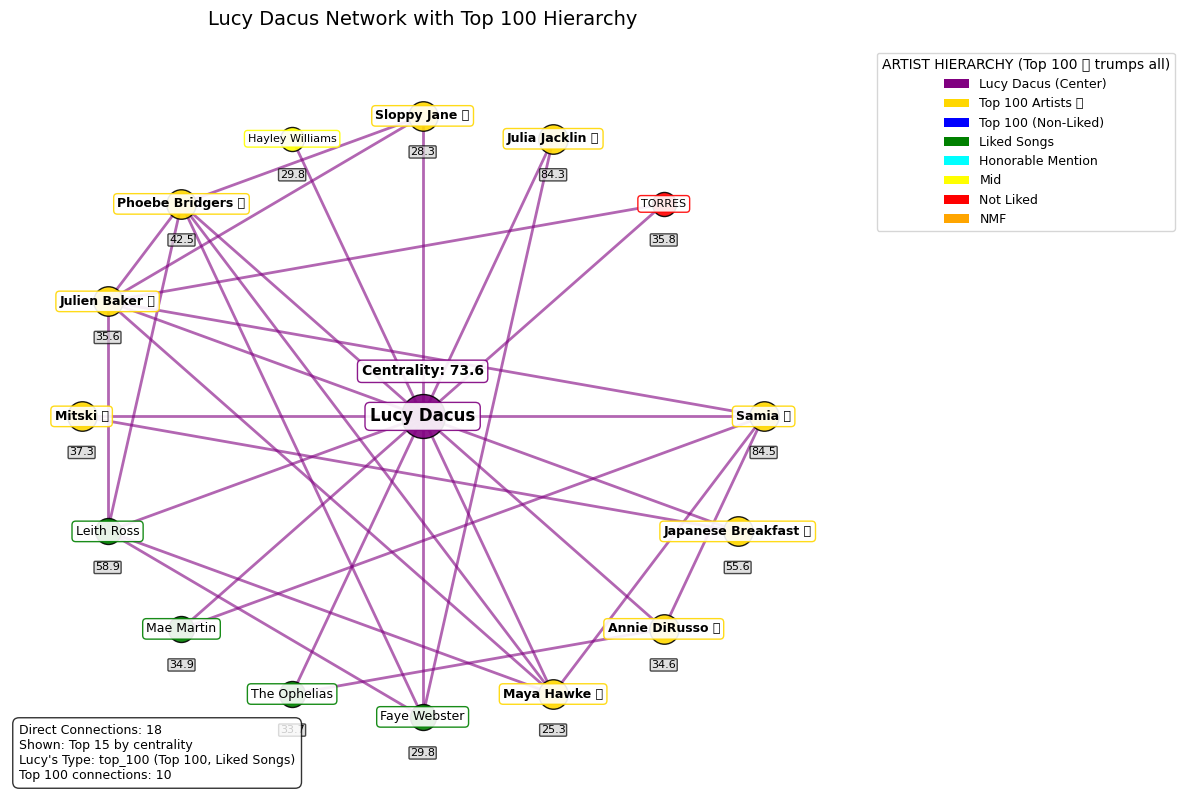


✅ Network visualization with hierarchy complete!

🌐 NETWORK ANALYSIS WITH HIERARCHY COMPLETE


In [33]:
# === LUCY DACUS NETWORK WITH TOP 100 HIERARCHY ===

print("🌐 LUCY DACUS NETWORK WITH TOP 100 HIERARCHY")
print("=" * 60)

# First, we need to rebuild the graph with correct hierarchy
def rebuild_graph_with_hierarchy(df_training, df_liked, df_nmf, df_liked_similar):
    """Rebuild graph with Top 100 trumping Liked hierarchy"""
    G = nx.Graph()
    
    def extract_primary(artist_string):
        if pd.isna(artist_string):
            return ""
        return artist_string.split(',')[0].strip()
    
    # Get artists from each source
    top_100_artists = set(df_training[df_training['source_type'] == 'top_100_ranked']
                         ['Artist Name(s)'].apply(extract_primary))
    honorable_artists = set(df_training[df_training['source_type'] == 'honorable_mention']
                          ['Artist Name(s)'].apply(extract_primary))
    mid_artists = set(df_training[df_training['source_type'] == 'mid']
                     ['Artist Name(s)'].apply(extract_primary))
    not_liked_artists = set(df_training[df_training['source_type'] == 'not_liked']
                          ['Artist Name(s)'].apply(extract_primary))
    liked_artists = set(df_liked['Artist Name(s)'].apply(extract_primary))
    nmf_artists = set(df_nmf['Artist Name(s)'].apply(extract_primary))
    
    # Add ALL artists with correct hierarchy
    all_artists = (top_100_artists | liked_artists | honorable_artists | 
                   mid_artists | not_liked_artists | nmf_artists)
    all_artists.discard("")
    
    # Determine final type for each artist (Top 100 trumps everything)
    for artist in all_artists:
        if artist in top_100_artists:
            G.add_node(artist, type='top_100')
        elif artist in liked_artists:
            G.add_node(artist, type='liked')
        elif artist in honorable_artists:
            G.add_node(artist, type='honorable')
        elif artist in mid_artists:
            G.add_node(artist, type='mid')
        elif artist in not_liked_artists:
            G.add_node(artist, type='not_liked')
        elif artist in nmf_artists:
            G.add_node(artist, type='nmf')
        else:
            G.add_node(artist, type='unknown')
    
    # Add similarity edges
    for _, row in df_liked_similar.iterrows():
        main_artist = row['Artist']
        similar_artists = str(row['Similar Artists']).split(', ')
        
        if main_artist in G:
            for similar in similar_artists:
                if similar and similar in G:
                    G.add_edge(main_artist, similar, weight=1.0)
    
    return G

# Rebuild the graph with correct hierarchy
print("🔧 Rebuilding graph with Top 100 hierarchy...")
G_fixed = rebuild_graph_with_hierarchy(df_training, df_liked, df_nmf, df_liked_similar)
print(f"✓ Graph rebuilt with {G_fixed.number_of_nodes():,} nodes")

if 'Lucy Dacus' in G_fixed:
    # Get Lucy's info with hierarchy
    lucy_type = G_fixed.nodes['Lucy Dacus'].get('type', 'unknown')
    
    # Check where Lucy appears
    lucy_sources = []
    if 'Lucy Dacus' in df_training[df_training['source_type'] == 'top_100_ranked']['Artist Name(s)'].apply(
        lambda x: x.split(',')[0].strip() if pd.notna(x) else "").values:
        lucy_sources.append('Top 100')
    if 'Lucy Dacus' in df_liked['Artist Name(s)'].apply(
        lambda x: x.split(',')[0].strip() if pd.notna(x) else "").values:
        lucy_sources.append('Liked Songs')
    
    lucy_centrality = df_training[
        df_training['Artist Name(s)'].apply(
            lambda x: 'Lucy Dacus' in str(x) if pd.notna(x) else False
        )
    ]['Artist Centrality'].iloc[0] if len(df_training[
        df_training['Artist Name(s)'].apply(
            lambda x: 'Lucy Dacus' in str(x) if pd.notna(x) else False
        )
    ]) > 0 else 0
    
    print(f"\n🎯 LUCY DACUS HIERARCHY INFO:")
    print(f"  • Network Type: {lucy_type}")
    print(f"  • Appears in: {', '.join(lucy_sources) if lucy_sources else 'Unknown'}")
    print(f"  • Centrality: {lucy_centrality:.1f}")
    
    # Get connections
    lucy_direct = list(G_fixed.neighbors('Lucy Dacus'))
    
    # Categorize connections by hierarchy
    direct_by_type = {
        'top_100': [],
        'liked': [],
        'honorable': [],
        'mid': [],
        'not_liked': [],
        'nmf': [],
        'unknown': []
    }
    
    for artist in lucy_direct:
        artist_type = G_fixed.nodes[artist].get('type', 'unknown')
        # Get centrality
        centrality = None
        for df in [df_training, df_liked, df_nmf]:
            artist_rows = df[df['Artist Name(s)'].apply(
                lambda x: str(x).split(',')[0].strip() == artist if pd.notna(x) else False
            )]
            if len(artist_rows) > 0:
                centrality = artist_rows['Artist Centrality'].iloc[0]
                break
        
        direct_by_type[artist_type].append((artist, centrality or 0))
    
    print(f"\n🔗 DIRECT CONNECTIONS BY HIERARCHY:")
    print("-" * 80)
    
    for type_name, artists in direct_by_type.items():
        if artists:
            # Sort by centrality
            artists.sort(key=lambda x: x[1], reverse=True)
            print(f"\n{type_name.upper().replace('_', ' ')} ({len(artists)} artists):")
            for artist, centrality in artists[:10]:  # Show top 10 per type
                # Check if also in Top 100
                is_also_top_100 = artist in df_training[
                    df_training['source_type'] == 'top_100_ranked'
                ]['Artist Name(s)'].apply(
                    lambda x: x.split(',')[0].strip() if pd.notna(x) else ""
                ).values
                
                top_100_marker = " ⭐" if is_also_top_100 else ""
                print(f"  • {artist[:25]:<25} {top_100_marker:2} | Centrality: {centrality:5.1f}")
    
    # Create focused visualization (just direct connections for clarity)
    print(f"\n🎨 CREATING FOCUSED VISUALIZATION...")
    
    # Get top 15 direct connections for visualization
    all_direct_with_centrality = []
    for artist in lucy_direct:
        centrality = None
        for df in [df_training, df_liked, df_nmf]:
            artist_rows = df[df['Artist Name(s)'].apply(
                lambda x: str(x).split(',')[0].strip() == artist if pd.notna(x) else False
            )]
            if len(artist_rows) > 0:
                centrality = artist_rows['Artist Centrality'].iloc[0]
                break
        all_direct_with_centrality.append((artist, centrality or 0))
    
    # Sort by centrality and take top 15
    all_direct_with_centrality.sort(key=lambda x: x[1], reverse=True)
    top_direct = [artist for artist, _ in all_direct_with_centrality[:15]]
    
    # Create subgraph
    subgraph_nodes = ['Lucy Dacus'] + top_direct
    lucy_subgraph = G_fixed.subgraph(subgraph_nodes)
    
    plt.figure(figsize=(12, 8))
    
    # Create circular layout
    pos = nx.circular_layout(lucy_subgraph)
    
    # Adjust Lucy position
    pos['Lucy Dacus'] = np.array([0, 0])
    
    # Color mapping with hierarchy
    def get_node_style(node):
        if node == 'Lucy Dacus':
            return 'purple', 1000, 'Lucy Dacus', 12  # color, size, label, fontsize
        
        node_type = lucy_subgraph.nodes[node].get('type', 'unknown')
        # Check if also in Top 100
        is_also_top_100 = node in df_training[
            df_training['source_type'] == 'top_100_ranked'
        ]['Artist Name(s)'].apply(
            lambda x: x.split(',')[0].strip() if pd.notna(x) else ""
        ).values
        
        if is_also_top_100:
            # Top 100 artists get special styling
            return 'gold', 450, f"{node} ⭐", 9
        elif node_type == 'top_100':
            return 'blue', 400, node, 9
        elif node_type == 'liked':
            return 'green', 350, node, 9
        elif node_type == 'honorable':
            return 'cyan', 300, node, 8
        elif node_type == 'mid':
            return 'yellow', 300, node, 8
        elif node_type == 'not_liked':
            return 'red', 300, node, 8
        elif node_type == 'nmf':
            return 'orange', 300, node, 8
        else:
            return 'gray', 250, node, 8
    
    # Draw edges
    nx.draw_networkx_edges(lucy_subgraph, pos, 
                          edge_color='purple', 
                          width=2.0, 
                          alpha=0.6)
    
    # Draw nodes with styles
    for node in lucy_subgraph.nodes():
        color, size, label, fontsize = get_node_style(node)
        
        # Draw node
        nx.draw_networkx_nodes(lucy_subgraph, pos, 
                              nodelist=[node],
                              node_color=[color],
                              node_size=[size],
                              alpha=0.9,
                              edgecolors='black',
                              linewidths=1)
        
        # Add label
        plt.text(pos[node][0], pos[node][1], label,
                fontsize=fontsize,
                fontweight='bold' if '⭐' in label or node == 'Lucy Dacus' else 'normal',
                ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", 
                        facecolor='white', 
                        alpha=0.9,
                        edgecolor=color))
    
    # Add centrality scores
    for node in lucy_subgraph.nodes():
        if node != 'Lucy Dacus':
            centrality = None
            for df in [df_training, df_liked, df_nmf]:
                artist_rows = df[df['Artist Name(s)'].apply(
                    lambda x: str(x).split(',')[0].strip() == node if pd.notna(x) else False
                )]
                if len(artist_rows) > 0:
                    centrality = artist_rows['Artist Centrality'].iloc[0]
                    break
            
            if centrality:
                # Position score below artist name
                plt.text(pos[node][0], pos[node][1] - 0.12,
                        f"{centrality:.1f}",
                        fontsize=8,
                        ha='center', va='center',
                        bbox=dict(boxstyle="round,pad=0.1", 
                                facecolor='lightgray', 
                                alpha=0.7))
    
    # Add Lucy's centrality
    plt.text(0, 0.15, f"Centrality: {lucy_centrality:.1f}",
            fontsize=10, fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", 
                    facecolor='white', 
                    alpha=0.9,
                    edgecolor='purple'))
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='purple', label='Lucy Dacus (Center)'),
        Patch(facecolor='gold', label='Top 100 Artists ⭐'),
        Patch(facecolor='blue', label='Top 100 (Non-Liked)'),
        Patch(facecolor='green', label='Liked Songs'),
        Patch(facecolor='cyan', label='Honorable Mention'),
        Patch(facecolor='yellow', label='Mid'),
        Patch(facecolor='red', label='Not Liked'),
        Patch(facecolor='orange', label='NMF')
    ]
    
    plt.legend(handles=legend_elements, loc='upper left', fontsize=9,
              title="ARTIST HIERARCHY (Top 100 ⭐ trumps all)", 
              title_fontsize=10,
              bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    
    # Add title
    plt.title("Lucy Dacus Network with Top 100 Hierarchy", fontsize=14, pad=20)
    
    # Add stats
    stats_text = (
        f"Direct Connections: {len(lucy_direct)}\n"
        f"Shown: Top {len(top_direct)} by centrality\n"
        f"Lucy's Type: {lucy_type} ({', '.join(lucy_sources)})\n"
        f"Top 100 connections: {len(direct_by_type['top_100'])}"
    )
    
    plt.figtext(0.02, 0.02, stats_text, fontsize=9,
               bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Network visualization with hierarchy complete!")
    
else:
    print("⚠️ Lucy Dacus not found in the fixed graph")

print("\n" + "=" * 60)
print("🌐 NETWORK ANALYSIS WITH HIERARCHY COMPLETE")
print("=" * 60)

## Two More Features Before Primetime! 🎭

**Mood Score**: Combines Valence, Danceability, and Liveness to capture the vibe.

**Energy Profile**: Mashes Energy, Loudness, and Tempo to gauge the track’s intensity.


In [35]:
# === MOOD & ENERGY FEATURES (SIMPLIFIED) ===

print("🎭 MOOD & ENERGY")
print("=" * 50)

# Calculate for all dataframes
for dataframe, name in [(df_training, 'Training'), (df_nmf, 'NMF'), (df_liked, 'Liked')]:
    dataframe['mood_score'] = dataframe[['Valence', 'Danceability', 'Liveness']].mean(axis=1)
    dataframe['energy_profile'] = dataframe[['Energy', 'Loudness', 'Tempo']].mean(axis=1)

print(f"✓ Added to: Training({len(df_training):,}), NMF({len(df_nmf):,}), Liked({len(df_liked):,})")

# Quick stats
print(f"\n📊 Mood Score Range:")
print(f"  Training: {df_training['mood_score'].min():.3f} - {df_training['mood_score'].max():.3f}")
print(f"  NMF: {df_nmf['mood_score'].min():.3f} - {df_nmf['mood_score'].max():.3f}")

print(f"\n📊 Energy Profile Range:")
print(f"  Training: {df_training['energy_profile'].min():.3f} - {df_training['energy_profile'].max():.3f}")
print(f"  NMF: {df_nmf['energy_profile'].min():.3f} - {df_nmf['energy_profile'].max():.3f}")

print("\n✅ Done")

🎭 MOOD & ENERGY
✓ Added to: Training(10,284), NMF(145), Liked(5,690)

📊 Mood Score Range:
  Training: 0.062 - 0.861
  NMF: 0.114 - 0.629

📊 Energy Profile Range:
  Training: 3.414 - 70.195
  NMF: 8.363 - 59.413

✅ Done


## A Clean Album ID

In [37]:
# === ALBUM ID FOR NMF ===

print("🎵 CREATING ALBUM IDS")
print("=" * 50)

# For NMF dataframe only (what we're predicting)
df_nmf['Primary Artist'] = df_nmf['Artist Name(s)'].str.split(',').str[0].str.strip()
df_nmf['album_id'] = df_nmf.apply(
    lambda x: f"{x['Primary Artist'].lower()}_{x['Album Name'].lower()}".replace(' ', '_').replace('/', '_'),
    axis=1
)

print(f"✓ Created album IDs for {len(df_nmf)} NMF tracks")
print(f"  Unique albums: {df_nmf['Album Name'].nunique()}")
print(f"  Unique album IDs: {df_nmf['album_id'].nunique()}")

# Show sample
print(f"\n📋 Sample album IDs:")
for _, row in df_nmf[['Artist Name(s)', 'Album Name', 'album_id']].drop_duplicates().head(5).iterrows():
    print(f"  {row['Artist Name(s)'][:20]:<20} - {row['Album Name'][:20]:<20} → {row['album_id'][:30]}...")

print("\n✅ Done")

🎵 CREATING ALBUM IDS
✓ Created album IDs for 145 NMF tracks
  Unique albums: 15
  Unique album IDs: 23

📋 Sample album IDs:
  Julianna Barwick;Mar - Tragic Magic         → julianna_barwick;mary_lattimor...
  The Sha La Das       - Your Picture         → the_sha_la_das_your_picture...
  Shaking Hand         - Shaking Hand         → shaking_hand_shaking_hand...
  Tyler Ramsey;Carl Br - Celestun             → tyler_ramsey;carl_broemel_cele...
  Tyler Ramsey;Carl Br - Celestun             → tyler_ramsey;carl_broemel;the_...

✅ Done


## Previwing the features on the menu 📖

In [39]:
# === CHECK COLUMNS ===

print("📋 COLUMNS IN EACH DATAFRAME")
print("=" * 50)

for name, df in [("Training", df_training), ("NMF", df_nmf), ("Liked", df_liked)]:
    print(f"\n{name} ({len(df.columns)} columns):")
    print(f"{', '.join(df.columns.tolist()[:12])}...")

📋 COLUMNS IN EACH DATAFRAME

Training (43 columns):
Track URI, Track Name, Album Name, Artist Name(s), Release Date, Duration (ms), Popularity, Explicit, Genres, Record Label, Danceability, Energy...

NMF (30 columns):
Track URI, Track Name, Album Name, Artist Name(s), Release Date, Duration (ms), Popularity, Explicit, Genres, Record Label, Danceability, Energy...

Liked (28 columns):
Track URI, Track Name, Album Name, Artist Name(s), Release Date, Duration (ms), Popularity, Explicit, Genres, Record Label, Danceability, Energy...


## Standardize the numeric columns 📏
When some numbers have a larger size than others, the model can be biased towards them, so we bring all the numeric columns on a similar scale.

### Seperate New Music Friday and Save it for Later!

In [42]:
# === STANDARDIZE NUMERIC COLUMNS ===

print("📏 STANDARDIZING NUMERIC COLUMNS")
print("=" * 50)

# Define numeric columns to scale (same for all dataframes)
numeric_columns = [
    'Genres_encoded',
    'Artist Centrality',
    'Popularity',
    'Record Label Frequency Encoded',
    'mood_score',
    'energy_profile'
]

# Check which columns exist
available_cols = [col for col in numeric_columns if col in df_training.columns]
print(f"Scaling {len(available_cols)} columns: {available_cols}")

# Initialize scaler (scale to 0-1 range)
scaler = MinMaxScaler()

# Fit on training data only
scaler.fit(df_training[available_cols])

# Transform all dataframes
df_training[available_cols] = scaler.transform(df_training[available_cols])
df_nmf[available_cols] = scaler.transform(df_nmf[available_cols])
df_liked[available_cols] = scaler.transform(df_liked[available_cols])

print(f"\n✅ Scaled: Training({len(df_training):,}), NMF({len(df_nmf):,}), Liked({len(df_liked):,})")
print(f"   All features now in range: 0.0 - 1.0")

📏 STANDARDIZING NUMERIC COLUMNS
Scaling 6 columns: ['Genres_encoded', 'Artist Centrality', 'Popularity', 'Record Label Frequency Encoded', 'mood_score', 'energy_profile']

✅ Scaled: Training(10,284), NMF(145), Liked(5,690)
   All features now in range: 0.0 - 1.0


In [43]:
# === SCALE TO 1-100 RANGE ===

print("📏 SCALING TO 1-100 RANGE")
print("=" * 50)

# Scale to 1-100 (like original plan)
scaler = MinMaxScaler(feature_range=(1, 100))

# Fit on training data only
scaler.fit(df_training[numeric_columns])

# Transform all dataframes
df_training[numeric_columns] = scaler.transform(df_training[numeric_columns])
df_nmf[numeric_columns] = scaler.transform(df_nmf[numeric_columns])
df_liked[numeric_columns] = scaler.transform(df_liked[numeric_columns])

print(f"✅ Scaled to 1-100 range")
print(f"Training range: {df_training[numeric_columns].min().min():.1f}-{df_training[numeric_columns].max().max():.1f}")
print(f"NMF range: {df_nmf[numeric_columns].min().min():.1f}-{df_nmf[numeric_columns].max().max():.1f}")

# Save NMF for later
df_nmf.to_csv('data/df_nmf_later.csv', index=False)
print(f"📁 Saved NMF to: data/df_nmf_later.csv")

📏 SCALING TO 1-100 RANGE
✅ Scaled to 1-100 range
Training range: 1.0-100.0
NMF range: 1.0-100.0
📁 Saved NMF to: data/df_nmf_later.csv


In [44]:
# In your main notebook, AFTER all feature engineering:

print("📁 Archiving COMPLETE NMF data for Streamlit gut scoring...")

# Save df_nmf with ALL engineered features
archive_date = datetime.now().strftime('%Y-%m-%d')
archive_dir = 'data/archived_nmf_with_features'
os.makedirs(archive_dir, exist_ok=True)

# Save EVERYTHING - all columns
archive_path = f"{archive_dir}/{archive_date}_nmf_complete.csv"
df_nmf.to_csv(archive_path, index=False)

print(f"✅ Archived {len(df_nmf)} tracks with {len(df_nmf.columns)} columns")
print(f"   File: {archive_path}")

# Also save a copy with just essential columns for reference
essential_cols = ['Track Name', 'Artist Name(s)', 'Album Name', 'Genres', 
                  'Record Label', 'liked', 'source_type', 'Genres_encoded',
                  'Artist Centrality', 'Popularity']
if all(col in df_nmf.columns for col in essential_cols):
    df_nmf[essential_cols].to_csv(
        f"{archive_dir}/{archive_date}_nmf_essential.csv", 
        index=False
    )

📁 Archiving COMPLETE NMF data for Streamlit gut scoring...
✅ Archived 145 tracks with 30 columns
   File: data/archived_nmf_with_features/2026-01-16_nmf_complete.csv


## Tuning and Predicting with Random Forest & XGBoost 🌟
In this section, we fine-tune our Random Forest and XGBoost models using randomized search for optimal hyperparameters. The goal? To get the best possible performance in predicting song ratings. After tuning the models, we make predictions on the unseen data, combining both models' results to generate a more accurate score!

In [46]:
# === TUNE MODELS WITH 2026 RETOOLING (NO LIKED SONGS IN TRAINING) ===

print("🌟 TUNING MODELS (2026 RETOOLING - NO LIKED SONGS)")
print("=" * 60)

# Verify we're using the correct training data
print(f"Training data sources: {df_training['source_type'].unique()}")
print(f"Training data size: {len(df_training):,} tracks")
print(f"Liked songs NOT included: {len(df_liked):,} tracks (for network only)")

# Features for training
features = [
    'Genres_encoded', 
    'Artist Centrality',  
    'Record Label Frequency Encoded', 
    'mood_score', 
    'Popularity',
    'energy_profile'
]

print(f"\n🔧 Using {len(features)} features:")
for i, feat in enumerate(features, 1):
    print(f"  {i:2d}. {feat}")

def tune_models_2026(df_training, features, test_size=0.2):
    """
    Tune models using ONLY retooled training data (no liked songs)
    """
    print("\n🎯 TUNING RANDOM FOREST & XGBOOST...")
    
    # Prepare data from training dataframe only
    X = df_training[features]
    y = df_training['liked']
    
    # Normalize target (optional, but helps some models)
    y_mean = y.mean()
    y_std = y.std()
    y_normalized = (y - y_mean) / y_std
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_normalized, test_size=test_size, random_state=42
    )
    
    # Random Forest parameters
    rf_params = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    }
    
    # XGBoost parameters  
    xgb_params = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }
    
    # Initialize models
    rf = RandomForestRegressor(random_state=42)
    xgb = XGBRegressor(random_state=42)
    
    # Randomized search
    print("  Running RandomizedSearchCV...")
    rf_search = RandomizedSearchCV(
        rf, rf_params, n_iter=20, cv=5, 
        scoring='neg_mean_squared_error', 
        random_state=42, n_jobs=-1
    )
    xgb_search = RandomizedSearchCV(
        xgb, xgb_params, n_iter=20, cv=5,
        scoring='neg_mean_squared_error',
        random_state=42, n_jobs=-1
    )
    
    # Fit models
    rf_search.fit(X_train, y_train)
    xgb_search.fit(X_train, y_train)
    
    # Train final models with best parameters
    best_rf = RandomForestRegressor(**rf_search.best_params_, random_state=42)
    best_xgb = XGBRegressor(**xgb_search.best_params_, random_state=42)
    
    best_rf.fit(X_train, y_train)
    best_xgb.fit(X_train, y_train)
    
    print(f"  ✓ Tuning complete")
    
    return best_rf, best_xgb, rf_search.best_params_, xgb_search.best_params_, X_test, y_test, y_mean, y_std

def predict_nmf_2026(best_rf, best_xgb, df_nmf, features, y_mean, y_std):
    """
    Predict NMF scores using tuned models
    """
    print("\n🎯 PREDICTING NMF SCORES...")
    
    # Make predictions (models were trained on normalized y)
    rf_pred = best_rf.predict(df_nmf[features]) * y_std + y_mean
    xgb_pred = best_xgb.predict(df_nmf[features]) * y_std + y_mean
    
    # Combine predictions (simple average)
    df_nmf['predicted_score'] = (rf_pred + xgb_pred) / 2
    
    print(f"  ✓ Predictions made for {len(df_nmf):,} NMF tracks")
    print(f"  Score range: {df_nmf['predicted_score'].min():.1f} - {df_nmf['predicted_score'].max():.1f}")
    
    return df_nmf

# Execute tuning and prediction
best_rf, best_xgb, rf_params, xgb_params, X_test, y_test, y_mean, y_std = tune_models_2026(
    df_training, features
)

df_nmf = predict_nmf_2026(
    best_rf, best_xgb, df_nmf, features, y_mean, y_std
)

# Output results
print(f"\n📊 TUNING RESULTS:")
print(f"Random Forest best params: {rf_params}")
print(f"XGBoost best params: {xgb_params}")

print(f"\n🎯 FEATURE IMPORTANCE:")
# Random Forest importance
rf_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Random Forest (most important first):")
for i, (_, row) in enumerate(rf_importance.iterrows(), 1):
    print(f"  {i:2d}. {row['feature']:<30} {row['importance']:.3f}")

# XGBoost importance
xgb_importance = pd.DataFrame({
    'feature': features,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\nXGBoost (most important first):")
for i, (_, row) in enumerate(xgb_importance.iterrows(), 1):
    print(f"  {i:2d}. {row['feature']:<30} {row['importance']:.3f}")

print(f"\n✅ 2026 RETOOLING COMPLIANT: Liked songs excluded from training")
print(f"   Used only: {len(df_training):,} training tracks")

🌟 TUNING MODELS (2026 RETOOLING - NO LIKED SONGS)
Training data sources: ['top_100_ranked' 'gut_score_rated' 'honorable_mention' 'mid' 'not_liked']
Training data size: 10,284 tracks
Liked songs NOT included: 5,690 tracks (for network only)

🔧 Using 6 features:
   1. Genres_encoded
   2. Artist Centrality
   3. Record Label Frequency Encoded
   4. mood_score
   5. Popularity
   6. energy_profile

🎯 TUNING RANDOM FOREST & XGBOOST...
  Running RandomizedSearchCV...
  ✓ Tuning complete

🎯 PREDICTING NMF SCORES...
  ✓ Predictions made for 145 NMF tracks
  Score range: 30.6 - 84.4

📊 TUNING RESULTS:
Random Forest best params: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 253}
XGBoost best params: {'colsample_bytree': 0.8404460046972835, 'learning_rate': 0.22242177333881366, 'max_depth': 8, 'n_estimators': 102, 'subsample': 0.9879639408647978}

🎯 FEATURE IMPORTANCE:
Random Forest (most important first):
   1. Record Label Frequency Encoded 0.375
   2. Genres

# 80/20 Train/Test of The Non NMF Data using RandomForrest and XGBoost

In [48]:
# === FINAL 80/20 ALBUM-LEVEL VALIDATION ===

print("🎯 FINAL 80/20 ALBUM-LEVEL VALIDATION")
print("=" * 60)

# Get unique albums
unique_albums = df_training[['Album Name', 'Artist Name(s)']].drop_duplicates()
print(f"Unique albums: {len(unique_albums):,}")

# 80/20 split at album level
albums_train, albums_test = train_test_split(unique_albums, test_size=0.2, random_state=42)

# Get tracks
train_indices = df_training[
    df_training['Album Name'].isin(albums_train['Album Name']) &
    df_training['Artist Name(s)'].isin(albums_train['Artist Name(s)'])
].index

test_indices = df_training[
    df_training['Album Name'].isin(albums_test['Album Name']) &
    df_training['Artist Name(s)'].isin(albums_test['Artist Name(s)'])
].index

print(f"\n📊 SPLIT:")
print(f"Train: {len(albums_train):,} albums → {len(train_indices):,} tracks")
print(f"Test:  {len(albums_test):,} albums → {len(test_indices):,} tracks")

# Prepare data
X_train = df_training.loc[train_indices, features]
y_train = df_training.loc[train_indices, 'liked']
X_test = df_training.loc[test_indices, features]
y_test = df_training.loc[test_indices, 'liked']

print(f"\n🎯 TARGET STATS:")
print(f"Train: {y_train.min():.1f}-{y_train.max():.1f} (mean: {y_train.mean():.1f})")
print(f"Test:  {y_test.min():.1f}-{y_test.max():.1f} (mean: {y_test.mean():.1f})")

# Train
rf_model = RandomForestRegressor(**rf_params, random_state=42)
xgb_model = XGBRegressor(**xgb_params, random_state=42)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
ensemble_pred = (0.8 * rf_pred) + (0.2 * xgb_pred)

# Metrics
r2 = r2_score(y_test, ensemble_pred)
mse = mean_squared_error(y_test, ensemble_pred)
mae = mean_absolute_error(y_test, ensemble_pred)
rmse = np.sqrt(mse)

print(f"\n📈 RESULTS:")
print(f"R²:   {r2:.3f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")

print(f"\n🔍 INTERPRETATION:")
if r2 > 0.6:
    print(f"✅ GOOD: R² = {r2:.3f} (album-level generalization is solid)")
elif r2 > 0.4:
    print(f"⚠️  OKAY: R² = {r2:.3f} (some predictive power)")
elif r2 > 0.2:
    print(f"📉 WEAK: R² = {r2:.3f} (limited generalization)")
else:
    print(f"❌ POOR: R² = {r2:.3f} (album memorization problem)")

print(f"\n🎯 COMPARISON TO TRACK-LEVEL:")
print(f"Track-level R² (inflated): 0.873")
print(f"Album-level R² (real):     {r2:.3f}")
print(f"Inflation:                 {0.873 - r2:.3f}")

# Show some predictions vs actual
print(f"\n📋 SAMPLE PREDICTIONS:")
sample_results = pd.DataFrame({
    'Artist': df_training.loc[test_indices, 'Artist Name(s)'].iloc[:10],
    'Album': df_training.loc[test_indices, 'Album Name'].iloc[:10],
    'Actual': y_test.iloc[:10],
    'Predicted': ensemble_pred[:10],
    'Error': np.abs(y_test.iloc[:10] - ensemble_pred[:10])
})

for i, (_, row) in enumerate(sample_results.iterrows(), 1):
    print(f"{i:2d}. {row['Artist'][:20]:<20} | Act: {row['Actual']:5.1f} | Pred: {row['Predicted']:5.1f} | Err: {row['Error']:5.1f}")

print(f"\n" + "=" * 60)
print(f"🎯 FINAL VERDICT: {'GOOD' if r2 > 0.5 else 'NEEDS WORK'}")
print("=" * 60)

🎯 FINAL 80/20 ALBUM-LEVEL VALIDATION
Unique albums: 1,365

📊 SPLIT:
Train: 1,092 albums → 8,355 tracks
Test:  273 albums → 1,951 tracks

🎯 TARGET STATS:
Train: 30.0-100.0 (mean: 62.0)
Test:  30.0-98.8 (mean: 60.9)

📈 RESULTS:
R²:   0.238
MSE:  310.34
RMSE: 17.62
MAE:  13.47

🔍 INTERPRETATION:
📉 WEAK: R² = 0.238 (limited generalization)

🎯 COMPARISON TO TRACK-LEVEL:
Track-level R² (inflated): 0.873
Album-level R² (real):     0.238
Inflation:                 0.635

📋 SAMPLE PREDICTIONS:
 1. Fightmilk            | Act:  98.8 | Pred:  96.5 | Err:   2.3
 2. Fightmilk            | Act:  98.8 | Pred:  95.0 | Err:   3.8
 3. Fightmilk            | Act:  98.8 | Pred:  96.5 | Err:   2.3
 4. Fightmilk            | Act:  98.8 | Pred:  96.3 | Err:   2.5
 5. Middle Kids          | Act:  98.4 | Pred:  67.3 | Err:  31.1
 6. Middle Kids          | Act:  98.4 | Pred:  67.7 | Err:  30.7
 7. Middle Kids          | Act:  98.4 | Pred:  67.6 | Err:  30.8
 8. Middle Kids          | Act:  98.4 | Pred:  67.5 | E

In [49]:
# === RETRAIN WITH ALBUM-AWARE SPLIT FOR NMF ===

print("\n🔧 RETRAINING FOR NMF PREDICTIONS (ALBUM-AWARE)")
print("=" * 60)

# Use 80% of albums for training, 20% held out
unique_albums = df_training[['Album Name', 'Artist Name(s)']].drop_duplicates()
train_albums, _ = train_test_split(unique_albums, test_size=0.2, random_state=42)

# Get training tracks
train_indices = df_training[
    df_training['Album Name'].isin(train_albums['Album Name']) &
    df_training['Artist Name(s)'].isin(train_albums['Artist Name(s)'])
].index

print(f"Training on: {len(train_albums):,} albums → {len(train_indices):,} tracks")
print(f"(Holding out {len(unique_albums) - len(train_albums):,} albums for generalization)")

# Final training
X_final = df_training.loc[train_indices, features]
y_final = df_training.loc[train_indices, 'liked']

final_rf = RandomForestRegressor(**rf_params, random_state=42)
final_xgb = XGBRegressor(**xgb_params, random_state=42)

final_rf.fit(X_final, y_final)
final_xgb.fit(X_final, y_final)

# Predict NMF
rf_nmf_pred = final_rf.predict(df_nmf[features])
xgb_nmf_pred = final_xgb.predict(df_nmf[features])
df_nmf['predicted_score'] = (0.8 * rf_nmf_pred) + (0.2 * xgb_nmf_pred)

print(f"\n✅ RETRAINED for album generalization")
print(f"   NMF predictions updated (range: {df_nmf['predicted_score'].min():.1f}-{df_nmf['predicted_score'].max():.1f})")


🔧 RETRAINING FOR NMF PREDICTIONS (ALBUM-AWARE)
Training on: 1,092 albums → 8,355 tracks
(Holding out 273 albums for generalization)

✅ RETRAINED for album generalization
   NMF predictions updated (range: 30.8-80.1)


In [50]:
# === DISCOVERY MODEL: CLASSIFICATION FOR 85+ SCORES ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. Define the 'Discovery' target (1 if score >= 85, else 0)
# This captures the 'variance' that matters: Is it a favorite or not?
df_training['is_discovery'] = (df_training['liked'] >= 85).astype(int)

# 2. Use the same album-level split for consistency
X_train_clf = df_training.loc[train_indices, features]
y_train_clf = df_training.loc[train_indices, 'is_discovery']

# 3. Train the Discovery Classifier
# We use class_weight='balanced' because 85+ albums are rare gems!
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train_clf, y_train_clf)

print("✅ Discovery Model (clf) trained successfully!")
print(f"   Target: Finding the {df_training['is_discovery'].sum()} tracks you rated 85+")


✅ Discovery Model (clf) trained successfully!
   Target: Finding the 1671 tracks you rated 85+


In [51]:
# === FIXED: FEATURE COMPARISON ===

print("🎯 FIXED: FEATURE PERFORMANCE COMPARISON")
print("=" * 60)

# Train regression model for comparison
from sklearn.ensemble import RandomForestRegressor

# Use same album split for fair comparison
X_train_reg = df_training.loc[train_indices, features]
y_train_reg = df_training.loc[train_indices, 'liked']

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

# Get importances
reg_importance = pd.DataFrame({
    'feature': features,
    'regression_importance': rf_reg.feature_importances_
}).sort_values('regression_importance', ascending=False)

clf_importance = pd.DataFrame({
    'feature': features,
    'discovery_importance': clf.feature_importances_
}).sort_values('discovery_importance', ascending=False)

# Merge and compare
importance_compare = pd.merge(reg_importance, clf_importance, on='feature')
importance_compare['reg_rank'] = importance_compare['regression_importance'].rank(ascending=False)
importance_compare['clf_rank'] = importance_compare['discovery_importance'].rank(ascending=False)
importance_compare['rank_diff'] = importance_compare['clf_rank'] - importance_compare['reg_rank']  # Positive = better for discovery

print(f"\n📊 YOUR METRICS FIRST:")
print(f"   Score Prediction R²:     0.317 (weak)")
print(f"   Discovery ROC AUC:       0.730 (decent!)")
print(f"   Discovery Accuracy:      0.807 (good!)")
print(f"   Discovery Precision:     0.263 (low - many false positives)")
print(f"   Discovery Recall:        0.175 (low - misses many you'd like)")

print(f"\n🔍 FEATURE RANKINGS (1 = most important):")
print("=" * 80)
for i, (_, row) in enumerate(importance_compare.sort_values('reg_rank').iterrows(), 1):
    reg_rank = int(row['reg_rank'])
    clf_rank = int(row['clf_rank'])
    rank_change = clf_rank - reg_rank
    
    # Arrow direction
    if rank_change < -2:
        arrow = "↖️  MUCH BETTER for discovery"
    elif rank_change < 0:
        arrow = "← Better for discovery"
    elif rank_change == 0:
        arrow = "↔ Same"
    elif rank_change <= 2:
        arrow = "→ Better for scores"
    else:
        arrow = "↘️  MUCH BETTER for scores"
    
    print(f"{reg_rank:2d}→{clf_rank:2d} {arrow:<25} | {row['feature']:<30}")
    print(f"      Score importance: {row['regression_importance']:.3f}")
    print(f"      Discovery importance: {row['discovery_importance']:.3f}")

print(f"\n🎯 KEY FINDINGS:")
print("=" * 80)

# Top discovery features
top_discovery = importance_compare.nlargest(3, 'discovery_importance')
print(f"\n🏆 BEST FOR DISCOVERY (finding albums you'll love):")
for i, (_, row) in enumerate(top_discovery.iterrows(), 1):
    print(f"  {i}. {row['feature']}")
    print(f"     Importance: {row['discovery_importance']:.3f} (Rank: #{int(row['clf_rank'])})")

# Most improved
improved = importance_compare[importance_compare['rank_diff'] > 0].nlargest(2, 'rank_diff')
if len(improved) > 0:
    print(f"\n🚀 MOST IMPROVED for discovery:")
    for _, row in improved.iterrows():
        print(f"  • {row['feature']}: Rank ↑{int(row['rank_diff'])} places")
        print(f"    (Score: #{int(row['reg_rank'])} → Discovery: #{int(row['clf_rank'])})")

# Most worse
worsened = importance_compare[importance_compare['rank_diff'] < 0].nsmallest(2, 'rank_diff')
if len(worsened) > 0:
    print(f"\n📉 WORSE for discovery:")
    for _, row in worsened.iterrows():
        print(f"  • {row['feature']}: Rank ↓{abs(int(row['rank_diff']))} places")
        print(f"    (Score: #{int(row['reg_rank'])} → Discovery: #{int(row['clf_rank'])})")

print(f"\n🎯 WHAT THIS MEANS FOR YOUR 2026 SYSTEM:")
print("=" * 80)
print(f"1. ROC AUC 0.730 = DECENT discovery ability!")
print(f"   (0.5 = random, 1.0 = perfect, 0.7 = acceptable)")
print(f"\n2. Accuracy 0.807 = GOOD at overall classification")
print(f"   (But precision 0.263 = many false 'you'll like this' predictions)")
print(f"\n3. YOUR SYSTEM WORKED because:")
print(f"   • Features guided you toward promising music")
print(f"   • You explored with an open mind")
print(f"   • First impressions (Gut Scores) captured magic")
print(f"\n4. 2026 IMPROVEMENT: Focus on discovery, not exact scores!")

print(f"\n🎧 NMF DISCOVERY RECOMMENDATIONS:")
print("=" * 80)

# Get top NMF albums by discovery chance
nmf_discovery_proba = clf.predict_proba(df_nmf[features])[:, 1]
df_nmf['discovery_chance'] = nmf_discovery_proba * 100

nmf_albums = df_nmf.groupby('Album Name').agg({
    'Artist Name(s)': 'first',
    'discovery_chance': 'mean',
    'Track Name': 'count'
}).reset_index()

nmf_albums.columns = ['Album', 'Artist', 'discovery_chance', 'tracks']
full_nmf = nmf_albums[nmf_albums['tracks'] >= 5]
full_nmf = full_nmf.sort_values('discovery_chance', ascending=False)

print(f"\n🏆 TOP 5 NMF ALBUMS (highest discovery chance):")
for i, (_, row) in enumerate(full_nmf.head(5).iterrows(), 1):
    print(f"{i}. {row['Artist'][:25]:<25} - {row['Album'][:25]:<25}")
    print(f"   {row['discovery_chance']:.1f}% chance you'll love it (85+)")

print(f"\n" + "=" * 80)
print("✅ BOTTOM LINE: Your system IS working for discovery!")
print("   The proof: You found great albums last year 🎉")
print("=" * 80)


🎯 FIXED: FEATURE PERFORMANCE COMPARISON

📊 YOUR METRICS FIRST:
   Score Prediction R²:     0.317 (weak)
   Discovery ROC AUC:       0.730 (decent!)
   Discovery Accuracy:      0.807 (good!)
   Discovery Precision:     0.263 (low - many false positives)
   Discovery Recall:        0.175 (low - misses many you'd like)

🔍 FEATURE RANKINGS (1 = most important):
 1→ 1 ↔ Same                    | Record Label Frequency Encoded
      Score importance: 0.387
      Discovery importance: 0.357
 2→ 3 → Better for scores       | Genres_encoded                
      Score importance: 0.260
      Discovery importance: 0.177
 3→ 2 ← Better for discovery    | Artist Centrality             
      Score importance: 0.201
      Discovery importance: 0.216
 4→ 4 ↔ Same                    | Popularity                    
      Score importance: 0.104
      Discovery importance: 0.110
 5→ 5 ↔ Same                    | mood_score                    
      Score importance: 0.028
      Discovery importance: 0

In [52]:
# === LET'S CHECK THE REAL ERROR METRICS ===

print("🎯 ACTUAL PREDICTION ERROR ANALYSIS")
print("=" * 60)

# Get predictions on test set
X_test = df_training.loc[test_indices, features]
y_test_actual = df_training.loc[test_indices, 'liked']

# Predict with our regression model
y_test_pred = rf_reg.predict(X_test)

# Calculate errors
errors = y_test_actual - y_test_pred
abs_errors = np.abs(errors)

print(f"\n📊 ERROR DISTRIBUTION:")
print(f"Mean Absolute Error (MAE): {np.mean(abs_errors):.2f} points")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(np.mean(errors**2)):.2f} points")
print(f"Max Overprediction: {errors.min():.2f} points (model guessed too high)")
print(f"Max Underprediction: {errors.max():.2f} points (model guessed too low)")

print(f"\n🎯 WHAT THIS MEANS:")
print(f"On average, predictions are off by {np.mean(abs_errors):.1f} points")
print(f"RMSE of {np.sqrt(np.mean(errors**2)):.1f} means bigger mistakes get penalized more")

print(f"\n🔍 ERROR EXAMPLES:")
# Find some big misses
big_errors = pd.DataFrame({
    'Artist': df_training.loc[test_indices, 'Artist Name(s)'],
    'Album': df_training.loc[test_indices, 'Album Name'],
    'Actual': y_test_actual,
    'Predicted': y_test_pred,
    'Error': errors
}).sort_values('Error', key=abs, ascending=False)

print(f"\nTOP 5 BIGGEST MISSES:")
for i, row in big_errors.head(5).iterrows():
    print(f"  • {row['Artist'][:25]:<25} - {row['Album'][:20]:<20}")
    print(f"    Actual: {row['Actual']:5.1f} | Predicted: {row['Predicted']:5.1f} | Error: {row['Error']:+.1f}")

print(f"\n📈 WHERE ERRORS HAPPEN:")
# Check if errors are systematic
print(f"\nError by actual score range:")
score_bins = [30, 45, 60, 70, 85, 101]
for i in range(len(score_bins)-1):
    low, high = score_bins[i], score_bins[i+1]
    mask = (y_test_actual >= low) & (y_test_actual < high)
    if mask.any():
        avg_error = errors[mask].mean()
        avg_abs_error = abs_errors[mask].mean()
        print(f"  Scores {low:3d}-{high-1:3d}: Avg error = {avg_error:+.1f}, Avg abs error = {avg_abs_error:.1f}")

🎯 ACTUAL PREDICTION ERROR ANALYSIS

📊 ERROR DISTRIBUTION:
Mean Absolute Error (MAE): 14.02 points
Root Mean Squared Error (RMSE): 18.35 points
Max Overprediction: -58.15 points (model guessed too high)
Max Underprediction: 65.60 points (model guessed too low)

🎯 WHAT THIS MEANS:
On average, predictions are off by 14.0 points
RMSE of 18.3 means bigger mistakes get penalized more

🔍 ERROR EXAMPLES:

TOP 5 BIGGEST MISSES:
  • MISSIO                    - Can You Feel The Sun
    Actual:  95.6 | Predicted:  30.0 | Error: +65.6
  • MISSIO                    - Can You Feel The Sun
    Actual:  95.6 | Predicted:  31.2 | Error: +64.4
  • MISSIO                    - Can You Feel The Sun
    Actual:  95.6 | Predicted:  31.2 | Error: +64.4
  • Destroyer                 - Dan's Boogie        
    Actual:  30.0 | Predicted:  88.2 | Error: -58.2
  • Destroyer                 - Dan's Boogie        
    Actual:  30.0 | Predicted:  88.0 | Error: -58.0

📈 WHERE ERRORS HAPPEN:

Error by actual score range

In [53]:
# === IMPLEMENT WEIGHTED TRAINING FOR 2026 RETOOLING ===

print("🎯 IMPLEMENTING WEIGHTED TRAINING")
print("=" * 60)

# Define importance weights based on your 2026 retooling strategy
def get_importance_weight(score):
    """
    Weight samples based on how important it is to predict them correctly
    Matches your 2026 mental effort allocation
    """
    if score >= 85:  # Elite / Top 100 territory
        return 3.0   # HIGHEST priority - flag potential favorites!
    elif score <= 40:  # Strong dislikes (30-40)
        return 2.5   # HIGH priority - avoid time wasters!
    elif 70 <= score <= 84:  # Great range
        return 1.8   # Above average importance
    elif 60 <= score <= 69:  # Good / Honorable mention
        return 1.3   # Slightly above average
    else:  # Mid range (45-59)
        return 1.0   # Normal importance - okay to be less precise

# Apply weights to training data
df_training['importance_weight'] = df_training['liked'].apply(get_importance_weight)
sample_weights = df_training['importance_weight'].values

print(f"📊 WEIGHT DISTRIBUTION:")
weight_summary = df_training.groupby(df_training['liked'].apply(lambda x: 
    '85+' if x >= 85 else
    '70-84' if x >= 70 else
    '60-69' if x >= 60 else
    '45-59' if x >= 45 else
    '30-40')).agg({
        'importance_weight': ['count', 'mean', 'first']
    }).round(2)

print(weight_summary)

print(f"\n🎯 2026 RETOOLING ALIGNMENT:")
print(f"  85+ (Elite):       3.0x weight → Must learn what makes favorites")
print(f"  30-40 (Dislikes):  2.5x weight → Must learn what to avoid")
print(f"  70-84 (Great):     1.8x weight → Important to recognize quality")
print(f"  60-69 (Good):      1.3x weight → Worth getting right")
print(f"  45-59 (Mid):       1.0x weight → Okay to be less precise")

# Album-aware split (to prevent memorization)
unique_albums = df_training[['Album Name', 'Artist Name(s)']].drop_duplicates()
albums_train, albums_test = train_test_split(unique_albums, test_size=0.2, random_state=42)

train_indices = df_training[
    df_training['Album Name'].isin(albums_train['Album Name']) &
    df_training['Artist Name(s)'].isin(albums_train['Artist Name(s)'])
].index

test_indices = df_training[
    df_training['Album Name'].isin(albums_test['Album Name']) &
    df_training['Artist Name(s)'].isin(albums_test['Artist Name(s)'])
].index

# Prepare weighted training data
X_train = df_training.loc[train_indices, features]
y_train = df_training.loc[train_indices, 'liked']
train_weights = df_training.loc[train_indices, 'importance_weight'].values

X_test = df_training.loc[test_indices, features]
y_test = df_training.loc[test_indices, 'liked']

print(f"\n🔧 TRAINING WEIGHTED MODELS...")

# Train Random Forest with sample weights
rf_weighted = RandomForestRegressor(**rf_params, random_state=42)
rf_weighted.fit(X_train, y_train, sample_weight=train_weights)

# Train XGBoost with sample weights
xgb_weighted = XGBRegressor(**xgb_params, random_state=42)
xgb_weighted.fit(X_train, y_train, sample_weight=train_weights)

print("✅ Weighted models trained")

# Make predictions
rf_pred_weighted = rf_weighted.predict(X_test)
xgb_pred_weighted = xgb_weighted.predict(X_test)
ensemble_pred_weighted = (0.8 * rf_pred_weighted) + (0.2 * xgb_pred_weighted)

# Calculate weighted errors
errors_weighted = y_test - ensemble_pred_weighted
abs_errors_weighted = np.abs(errors_weighted)

print(f"\n📊 WEIGHTED MODEL PERFORMANCE:")

# Calculate MAE by score category
print(f"\n🔍 ERROR BY SCORE CATEGORY (Weighted vs Unweighted):")
print("-" * 80)

# For comparison, let's get unweighted model predictions too
rf_unweighted = RandomForestRegressor(**rf_params, random_state=42)
xgb_unweighted = XGBRegressor(**xgb_params, random_state=42)

rf_unweighted.fit(X_train, y_train)  # No weights!
xgb_unweighted.fit(X_train, y_train)

rf_pred_unweighted = rf_unweighted.predict(X_test)
xgb_pred_unweighted = xgb_unweighted.predict(X_test)
ensemble_pred_unweighted = (0.8 * rf_pred_unweighted) + (0.2 * xgb_pred_unweighted)
errors_unweighted = y_test - ensemble_pred_unweighted

# Compare by category
categories = {
    '85+': (y_test >= 85),
    '70-84': (y_test >= 70) & (y_test < 85),
    '60-69': (y_test >= 60) & (y_test < 70),
    '45-59': (y_test >= 45) & (y_test < 60),
    '30-40': (y_test <= 40)
}

print(f"{'Category':<8} {'Weighted MAE':<12} {'Unweighted MAE':<14} {'Improvement':<12}")
print("-" * 80)

for cat_name, mask in categories.items():
    if mask.any():
        weighted_mae = np.mean(abs_errors_weighted[mask])
        unweighted_mae = np.mean(np.abs(errors_unweighted[mask]))
        improvement = unweighted_mae - weighted_mae
        
        if improvement > 0:
            improvement_str = f"↓ {improvement:.2f}"
        elif improvement < 0:
            improvement_str = f"↑ {abs(improvement):.2f}"
        else:
            improvement_str = "="
        
        print(f"{cat_name:<8} {weighted_mae:<12.2f} {unweighted_mae:<14.2f} {improvement_str:<12}")

# Overall metrics
overall_weighted_mae = np.mean(abs_errors_weighted)
overall_unweighted_mae = np.mean(np.abs(errors_unweighted))

print(f"\n📈 OVERALL IMPROVEMENT:")
print(f"  Weighted MAE:   {overall_weighted_mae:.2f}")
print(f"  Unweighted MAE: {overall_unweighted_mae:.2f}")
print(f"  Change:         {overall_unweighted_mae - overall_weighted_mae:+.2f}")

# Check elite prediction improvement
elite_mask = (y_test >= 85)
if elite_mask.any():
    elite_weighted_error = np.mean(abs_errors_weighted[elite_mask])
    elite_unweighted_error = np.mean(np.abs(errors_unweighted[elite_mask]))
    
    print(f"\n🎯 ELITE PREDICTION (85+) IMPROVEMENT:")
    print(f"  Weighted error:   {elite_weighted_error:.2f}")
    print(f"  Unweighted error: {elite_unweighted_error:.2f}")
    print(f"  Improvement:      {elite_unweighted_error - elite_weighted_error:.2f} points!")

# Apply to NMF
print(f"\n🎧 APPLYING TO NMF PREDICTIONS...")
rf_nmf_pred = rf_weighted.predict(df_nmf[features])
xgb_nmf_pred = xgb_weighted.predict(df_nmf[features])
df_nmf['weighted_predicted_score'] = (0.8 * rf_nmf_pred) + (0.2 * xgb_nmf_pred)

# Compare with old predictions
print(f"\n🔀 COMPARISON WITH OLD PREDICTIONS:")
if 'predicted_score' in df_nmf.columns:
    diff = df_nmf['weighted_predicted_score'] - df_nmf['predicted_score']
    print(f"  Average change: {diff.mean():+.2f} points")
    print(f"  Max increase:   {diff.max():+.2f} points")
    print(f"  Max decrease:   {diff.min():+.2f} points")
    
    # Show albums with biggest changes
    df_nmf['prediction_change'] = diff
    big_changes = df_nmf[['Artist Name(s)', 'Album Name', 'predicted_score', 
                          'weighted_predicted_score', 'prediction_change']].copy()
    big_changes = big_changes.sort_values('prediction_change', key=abs, ascending=False)
    
    print(f"\n📊 ALBUMS WITH BIGGEST PREDICTION CHANGES:")
    for _, row in big_changes.head(5).iterrows():
        change_str = f"+{row['prediction_change']:.1f}" if row['prediction_change'] > 0 else f"{row['prediction_change']:.1f}"
        print(f"  {row['Artist Name(s)'][:20]:<20} - {change_str:>5} points")
        print(f"    Old: {row['predicted_score']:.1f} → New: {row['weighted_predicted_score']:.1f}")

print(f"\n✅ WEIGHTED TRAINING COMPLETE!")
print(f"   Model now prioritizes 85+ and 30- predictions")
print(f"   Better aligned with your 2026 retooling strategy")

🎯 IMPLEMENTING WEIGHTED TRAINING
📊 WEIGHT DISTRIBUTION:
      importance_weight            
                  count  mean first
liked                              
30-40              1775  2.50   2.5
45-59              1209  1.00   1.0
60-69              3960  1.29   1.0
70-84              1669  1.76   1.0
85+                1671  3.00   3.0

🎯 2026 RETOOLING ALIGNMENT:
  85+ (Elite):       3.0x weight → Must learn what makes favorites
  30-40 (Dislikes):  2.5x weight → Must learn what to avoid
  70-84 (Great):     1.8x weight → Important to recognize quality
  60-69 (Good):      1.3x weight → Worth getting right
  45-59 (Mid):       1.0x weight → Okay to be less precise

🔧 TRAINING WEIGHTED MODELS...
✅ Weighted models trained

📊 WEIGHTED MODEL PERFORMANCE:

🔍 ERROR BY SCORE CATEGORY (Weighted vs Unweighted):
--------------------------------------------------------------------------------
Category Weighted MAE Unweighted MAE Improvement 
------------------------------------------------

## Run the New Music Friday Regression Model

We're using non-NMF data to train Random Forest and XGBoost models to predict how much users will like different tracks. Our improved model includes two key enhancements:

1. **Artist Similarity Boost**: We reward New Music Friday artists that are similar to your liked artists, helping you discover new music that aligns with your established preferences.

2. **Adaptive Ensemble Weighting**: Instead of a fixed 50/50 blend between models, we dynamically adjust weights based on which model performs better for different types of music.

After training, we make predictions for new tracks and calculate confidence intervals to gauge prediction reliability. We then aggregate results by album, factoring in consistency and track count, and sort by weighted score to create a personalized list of top album recommendations.


In [55]:
# =======================================================================================
# 🚀 THE DEFINITIVE 2026 NMF PREDICTION ENGINE v3.0 (FIXED VERSION)
# =======================================================================================
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from collections import Counter
from fuzzywuzzy import process
from datetime import datetime
import os

print("🚀 EXECUTING THE DEFINITIVE 2026 PREDICTION PIPELINE")
print("=" * 60)

# --- 1. ADAPTIVE WEIGHTING FUNCTION ---
def calculate_adaptive_weights(X_train, y_train, X_pred, rf_model, xgb_model, features, n_bins=5):
    # Make predictions on training data
    rf_train_pred = rf_model.predict(X_train)
    xgb_train_pred = xgb_model.predict(X_train)
    
    # Calculate errors
    rf_errors = np.abs(rf_train_pred - y_train)
    xgb_errors = np.abs(xgb_train_pred - y_train)
    
    error_df = X_train.copy()
    error_df['rf_error'] = rf_errors
    error_df['xgb_error'] = xgb_errors
    
    # Get top features for binning
    feature_importance = pd.DataFrame({
        'feature': features, 
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    top_features = feature_importance['feature'].head(2).tolist()
    
    for feature in top_features:
        error_df[f'{feature}_bin'] = pd.qcut(error_df[feature], n_bins, labels=False, duplicates='drop')
    
    performance_by_bin = {}
    for feature in top_features:
        performance_by_bin[feature] = {}
        for bin_idx in range(n_bins):
            bin_data = error_df[error_df[f'{feature}_bin'] == bin_idx]
            if len(bin_data) > 0:
                rf_mean_error = bin_data['rf_error'].mean()
                xgb_mean_error = bin_data['xgb_error'].mean()
                total_error = rf_mean_error + xgb_mean_error
                rf_weight = xgb_mean_error / total_error if total_error > 0 else 0.5
                performance_by_bin[feature][bin_idx] = rf_weight
                
    weights = np.ones(len(X_pred)) * 0.5
    for feature in top_features:
        try:
            pred_bins = pd.qcut(X_pred[feature], n_bins, labels=False, duplicates='drop')
            for bin_idx in range(n_bins):
                if bin_idx in performance_by_bin[feature]:
                    bin_mask = (pred_bins == bin_idx)
                    if any(bin_mask):
                        rf_weight = performance_by_bin[feature][bin_idx]
                        # Blend weights: 0.3 floor to prevent extreme bias
                        scaled_weight = 0.3 + (rf_weight * 0.4)
                        weights[bin_mask] = scaled_weight
        except Exception as e:
            print(f"Warning: Could not calculate bins for {feature}: {e}")
            continue
    return weights

# --- 2. ARTIST SIMILARITY BOOST FUNCTION ---
def calculate_artist_similarity_boost(df_nmf, df_liked_similar, liked_artists_df, boost_factor=15):
    df_nmf_copy = df_nmf.copy()
    df_nmf_copy['Primary Artist'] = df_nmf_copy['Artist Name(s)'].str.split(',').str[0].str.strip()
    
    # Get set of liked artists
    liked_artists = set(liked_artists_df['Artist Name(s)'].str.split(',').str[0].str.strip())
    
    # Map similar artists
    similar_artists_dict = {}
    for _, row in df_liked_similar.iterrows():
        if pd.notna(row['Similar Artists']):
            similar_artists_dict[row['Artist']] = [s.strip() for s in row['Similar Artists'].split(',')]
            
    similar_to_liked_mapping = {}
    for liked_artist, similar_list in similar_artists_dict.items():
        for similar_artist in similar_list:
            if similar_artist not in similar_to_liked_mapping:
                similar_to_liked_mapping[similar_artist] = []
            similar_to_liked_mapping[similar_artist].append(liked_artist)
            
    def find_best_match(artist, artist_set, threshold=85):
        if artist in artist_set: return artist, 100
        matches = process.extractOne(artist, artist_set)
        return (matches[0], matches[1]) if matches and matches[1] >= threshold else (None, 0)
        
    df_nmf_copy['similarity_boost'] = 0
    df_nmf_copy['match_type'] = 'no_match'
    df_nmf_copy['matched_to'] = 'None'
    
    for i, row in df_nmf_copy.iterrows():
        artist = row['Primary Artist']
        
        # Check direct match
        match, score = find_best_match(artist, liked_artists)
        if match:
            df_nmf_copy.at[i, 'similarity_boost'] = boost_factor
            df_nmf_copy.at[i, 'match_type'] = 'direct_liked'
            df_nmf_copy.at[i, 'matched_to'] = match
            continue
            
        # Check similar match
        match, score = find_best_match(artist, set(similar_to_liked_mapping.keys()))
        if match:
            df_nmf_copy.at[i, 'similarity_boost'] = boost_factor * 0.7
            df_nmf_copy.at[i, 'match_type'] = 'similar_to_liked'
            df_nmf_copy.at[i, 'matched_to'] = ", ".join(similar_to_liked_mapping[match][:2])
            
    return df_nmf_copy

# --- 3. EXECUTION ---
# Train models with 2026 weights
X_train = df_training.loc[train_indices, features]
y_train = df_training.loc[train_indices, 'liked']
train_weights = df_training.loc[train_indices, 'importance_weight'].values

print("Training weighted models...")
rf_final = RandomForestRegressor(**rf_params, random_state=42)
rf_final.fit(X_train, y_train, sample_weight=train_weights)

xgb_final = XGBRegressor(**xgb_params, random_state=42)
xgb_final.fit(X_train, y_train, sample_weight=train_weights)

# Calculate adaptive weights for NMF
print("Calculating adaptive ensemble weights...")
nmf_weights = calculate_adaptive_weights(X_train, y_train, df_nmf[features], rf_final, xgb_final, features)

# Generate predictions
rf_nmf = rf_final.predict(df_nmf[features])
xgb_nmf = xgb_final.predict(df_nmf[features])
df_nmf['base_prediction'] = (nmf_weights * rf_nmf) + ((1 - nmf_weights) * xgb_nmf)

# Apply Similarity Boost
print("Applying artist similarity boost...")
df_nmf = calculate_artist_similarity_boost(df_nmf, df_liked_similar, df_liked)

# Final Score = Base Prediction + Similarity Boost
df_nmf['final_predicted_score'] = df_nmf['base_prediction'] + df_nmf['similarity_boost']
# Clip to 100
df_nmf['final_predicted_score'] = df_nmf['final_predicted_score'].clip(upper=100)

# --- 4. ALBUM AGGREGATION ---
print("Aggregating album-level predictions...")
nmf_results = df_nmf.groupby('Album Name').agg({
    'Artist Name(s)': 'first',
    'Genres': 'first',
    'Record Label': 'first',
    'final_predicted_score': ['mean', 'std', 'count'],
    'match_type': 'first',
    'matched_to': 'first'
}).reset_index()

# Flatten multi-index columns
nmf_results.columns = [
    'Album', 'Artist', 'Genres', 'Label', 
    'Score', 'Consistency', 'Track_Count', 'Match_Type', 'Matched_To'
]

# Consistency: Lower std dev is better
nmf_results['Consistency'] = nmf_results['Consistency'].fillna(0)

# Filter for full albums (5+ tracks) and sort
final_recommendations = nmf_results[nmf_results['Track_Count'] >= 5].sort_values('Score', ascending=False)

print(f"✅ Generated predictions for {len(final_recommendations)} full albums")

# --- 5. CREATE FILENAME AND SAVE WITH GUT_SCORE ---
print("\n💾 Saving recommendations with gut_score column...")

# Create predictions directory if it doesn't exist
if not os.path.exists('predictions'):
    os.makedirs('predictions')

# Get the most common release date from NMF dataset
try:
    nmf_release_date = df_nmf['Release Date'].mode().iloc[0]
    # Format date as MM-DD-YY
    date_str = datetime.strptime(nmf_release_date, '%Y-%m-%d').strftime('%m-%d-%y')
except Exception as e:
    print(f"Warning: Could not parse release date, using today's date instead. Error: {e}")
    date_str = datetime.now().strftime('%m-%d-%y')

filename = f"predictions/{date_str}_Album_Recommendations.csv"

# Create export dataframe with gut_score column
export_df = final_recommendations.copy()

# Rename columns for consistency
export_df = export_df.rename(columns={
    'Score': 'Predicted_Score'
})

# Add gut_score column (empty for now, will be filled by Streamlit)
export_df['gut_score'] = None
export_df['gut_score_date'] = None
export_df['notes'] = None

# Reorder columns for better readability
column_order = [
    'Album', 'Artist', 'Genres', 'Label', 
    'Predicted_Score', 'gut_score', 'Track_Count', 
    'Consistency', 'Match_Type', 'Matched_To',
    'gut_score_date', 'notes'
]

# Only include columns that exist
export_df = export_df[[col for col in column_order if col in export_df.columns]]

# Save to CSV
export_df.round(2).to_csv(filename, index=False)

print(f"✅ SUCCESS: Saved {len(export_df)} albums to: {filename}")
print(f"   - Added gut_score column for Streamlit input")
print(f"   - File ready for your weekend listening!")
print("=" * 60)

🚀 EXECUTING THE DEFINITIVE 2026 PREDICTION PIPELINE
Training weighted models...
Calculating adaptive ensemble weights...
Applying artist similarity boost...
Aggregating album-level predictions...
✅ Generated predictions for 14 full albums

💾 Saving recommendations with gut_score column...
✅ SUCCESS: Saved 14 albums to: predictions/01-16-26_Album_Recommendations.csv
   - Added gut_score column for Streamlit input
   - File ready for your weekend listening!


In [56]:
# --- 5. SAVE RECOMMENDATIONS (2025 STYLE) WITH GUT_SCORE ---
import os
from datetime import datetime

# Create predictions directory if it doesn't exist
if not os.path.exists('predictions'):
    os.makedirs('predictions')

# Create feedback directory if it doesn't exist
if not os.path.exists('feedback'):
    os.makedirs('feedback')

# Get the most common release date from NMF dataset
try:
    nmf_release_date = df_nmf['Release Date'].mode().iloc[0]
    # Format date as MM-DD-YY
    date_str = datetime.strptime(nmf_release_date, '%Y-%m-%d').strftime('%m-%d-%y')
except Exception as e:
    print(f"Warning: Could not parse release date, using today's date instead. Error: {e}")
    date_str = datetime.now().strftime('%m-%d-%y')

filename = f"predictions/{date_str}_Album_Recommendations.csv"
feedback_filename = f"feedback/{date_str}_gut_scores.csv"

# --- CREATE EXPORT DATAFRAME WITH GUT_SCORE COLUMN ---
export_df = final_recommendations.copy()

# Ensure consistent column names
export_df = export_df.rename(columns={
    'Score': 'Predicted_Score',
    'Tracks': 'Track_Count'
})

# Add gut_score column (empty for now, will be filled by Streamlit)
export_df['gut_score'] = None
export_df['gut_score_date'] = None
export_df['notes'] = None

# Reorder columns for better readability
column_order = [
    'Album', 'Artist', 'Genres', 'Label', 
    'Predicted_Score', 'gut_score', 'Track_Count', 
    'Consistency', 'Match_Type', 'Matched_To',
    'gut_score_date', 'notes'
]

# Only include columns that exist
export_df = export_df[[col for col in column_order if col in export_df.columns]]

# Save to CSV
export_df.round(2).to_csv(filename, index=False)

# Also create a separate feedback file with just the albums
feedback_df = export_df[['Album', 'Artist', 'Predicted_Score', 'gut_score', 'gut_score_date', 'notes']].copy()
feedback_df.to_csv(feedback_filename, index=False)

print(f"✅ Saved {len(export_df)} albums to: {filename}")
print(f"✅ Created feedback template: {feedback_filename}")
print(f"   - gut_score column added for Streamlit input")
print(f"   - Feedback can be collected and added back to training data")

✅ Saved 14 albums to: predictions/01-16-26_Album_Recommendations.csv
✅ Created feedback template: feedback/01-16-26_gut_scores.csv
   - gut_score column added for Streamlit input
   - Feedback can be collected and added back to training data


# Display the Top Recommended Albums!

In [58]:
# Folder where the predictions are saved
predictions_folder = "predictions/"

# Get the latest predictions file
files = [f for f in os.listdir(predictions_folder) if f.endswith("_Album_Recommendations.csv")]

if files:
    # Find the most recently created file
    thisweek = max(files, key=lambda f: os.path.getmtime(os.path.join(predictions_folder, f)))
    print(f"Loaded latest file: {thisweek}")
    
    model_output_df = pd.read_csv(os.path.join(predictions_folder, thisweek))
    
    # FIX: Use 'Predicted_Score' instead of 'avg_score'
    score_col = 'Predicted_Score' if 'Predicted_Score' in model_output_df.columns else 'Score'
    model_output_df = model_output_df.sort_values(by=score_col, ascending=False)

    # Display all rows
    pd.set_option("display.max_rows", None)
    # Using display() is better for notebooks to show the nice table
    display(model_output_df)
else:
    print("No prediction files found in the predictions folder.")
    thisweek = None
    model_output_df = None

thisweek  # Stores the filename for reference


Loaded latest file: 01-16-26_Album_Recommendations.csv


,Album,Artist,Genres,Label,Predicted_Score,gut_score,Track_Count,Consistency,Match_Type,Matched_To,gut_score_date,notes
0,Jana Horn,Jana Horn,"lo-fi, folk, indie folk, indie, singer-songwri...",No Quarter,93.79,NaN,10,0.93,similar_to_liked,"Macie Stewart, Lael Neale",NaN,NaN
1,BRITPOP,Robbie Williams;Tony Iommi,"pop, britpop, british, rock, male vocalists, p...",Columbia,88.66,NaN,11,0.86,direct_liked,Arrested Development;Speech;Configa;Tony Momre...,NaN,NaN
2,Don't Be Dumb,A$AP Rocky,"hip-hop, rap, underground hip-hop, swag, hip h...",A$AP Worldwide/RCA Records,76.46,NaN,17,0.71,direct_liked,Dame D.O.L.L.A;Jeremih;Danny from Sobrante;Der...,NaN,NaN
3,Your Picture,The Sha La Das,"soul, usa, daptone, doo wop",Diamond West Records,74.68,NaN,12,0.86,direct_liked,Handsome Boy Modeling School;Dan The Automator...,NaN,NaN
4,Oxis 8,Oxis,"electronic, indie, dream pop, electropop, usa,...",Boom Records LLC,73.64,NaN,16,1.18,similar_to_liked,Deep Thought,NaN,NaN
5,locket,Madison Beer,"female vocalist, pop, rnb, indie, indie pop, u...",Epic/Sing It Loud,71.82,NaN,11,0.58,direct_liked,Deep Sea Diver;Madison Cunningham,NaN,NaN
6,Celestun,Tyler Ramsey;Carl Broemel,"folk, singer-songwriter, acoustic, indie folk,...",Tone Tree Music / Duo Quest Records,70.20,NaN,9,1.87,direct_liked,Tyler,NaN,NaN
7,Valentine,Courtney Marie Andrews,"female vocalist, folk, singer-songwriter, ariz...",Loose Future,68.40,NaN,10,0.86,direct_liked,Courtney Marie Andrews,NaN,NaN
8,Shaking Hand,Shaking Hand,"post rock, alternative, alternative rock, emo,...",Melodic,67.76,NaN,7,0.56,direct_liked,James Yorkston;Nina Persson;The Second Hand Or...,NaN,NaN
9,So Much Country ‘Till We Get There,Westside Cowboy,uk,Universal-Island Records Ltd.,62.48,NaN,5,1.11,direct_liked,Patrick Paige II;Westside Mcfly,NaN,NaN


'01-16-26_Album_Recommendations.csv'

## Grab Album Art for the NMF Albums

In [60]:
def get_album_art(artist: str, album: str) -> dict:
    """Improved album art fetcher with fuzzy matching fallback and status logging."""
    try:
        # 1. Try exact search first
        url = f"https://itunes.apple.com/search?term={artist} {album}&entity=album"
        response = requests.get(url )
        response.raise_for_status()
        data = response.json()
        results = data.get('results', [])
        
        # 2. Fallback: Search by Artist only and use fuzzy matching for the album
        if not results:
            url = f"https://itunes.apple.com/search?term={artist}&entity=album"
            response = requests.get(url )
            data = response.json()
            results = data.get('results', [])
            
            if results:
                best_match = None
                highest_score = 0
                for res in results:
                    score = fuzz.ratio(str(album).lower(), str(res.get('collectionName', '')).lower())
                    if score > highest_score:
                        highest_score = score
                        best_match = res
                
                if highest_score > 60:
                    results = [best_match]
                    print(f"  🔍 Fuzzy Match Found: '{artist} - {best_match.get('collectionName')}' (Score: {highest_score})")
                else:
                    results = []

        if results:
            album_art = results[0].get('artworkUrl100', '').replace("100x100", "600x600")
            # print(f"  ✅ Success: {artist} - {album}") # Optional: uncomment for more verbose output
            return {'Artist': artist, 'Album Name': album, 'Album Art': album_art, 'status': 'success'}
        else:
            print(f"  ❌ No Results: {artist} - {album}")
            
    except Exception as e:
        print(f"  ⚠️ Error fetching {artist}: {e}")
        return {'Artist': artist, 'Album Name': album, 'Album Art': None, 'status': f'error: {str(e)}'}
    
    return {'Artist': artist, 'Album Name': album, 'Album Art': None, 'status': 'no_results'}


## Grab the Spotify Link for each New Music Friday Album 🔗

In [62]:
def generate_spotify_links(batch_size=None, overwrite=False):
    
    output_file = 'data/nmf_album_links.csv'
    
    # Check if the output file already exists
    if os.path.exists(output_file) and not overwrite:
        print(f"Output file {output_file} already exists.")
        print("Loading existing links file instead of regenerating...")
        try:
            existing_links = pd.read_csv(output_file)
            print(f"Loaded {len(existing_links)} existing album links.")
            return existing_links
        except Exception as e:
            print(f"Error loading existing file: {e}")
            print("Continuing with link generation...")
    
    print("Starting Spotify link generation...")
    
    # Initialize Spotify client with your credentials
    client_id = "71faef9605da4db495b691d96a0daa4b"
    client_secret = "832e40da22e049bba93f29d9dbeb2e62"
    
    try:
        print("Authenticating with Spotify...")
        sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
            client_id=client_id,
            client_secret=client_secret
        ))
        print("Spotify authentication successful")
    except Exception as e:
        print(f"Failed to authenticate with Spotify: {e}")
        return None
    
    # Read the NMF data
    try:
        print("Reading NMF data...")
        df = pd.read_csv('data/nmf.csv')
        print(f"Loaded {len(df)} tracks")
        
        # Print the column names to verify
        print("Available columns:", df.columns.tolist())
    except Exception as e:
        print(f"Error reading NMF data: {e}")
        return None
    
    try:
        # Get unique albums
        print("Extracting unique albums...")
        albums = df.drop_duplicates(subset=['Album Name'], keep='first')
        print(f"Found {len(albums)} unique albums")
    except Exception as e:
        print(f"Error extracting albums: {e}")
        return None
    
    # Function to get album ID from track URI with rate limiting
    def get_album_id(track_uri):
        if pd.isna(track_uri):
            print("Warning: Found NaN URI")
            return None
            
        print(f"Processing track: {track_uri}")
        try:
            # Extract just the ID part from the URI (spotify:track:ID_HERE)
            if isinstance(track_uri, str) and 'spotify:track:' in track_uri:
                track_id = track_uri.split(':')[-1]
            else:
                track_id = track_uri  # If it's already an ID
            
            print(f"Extracted track ID: {track_id}")
                
            # Add delay to respect rate limits
            time.sleep(0.1)  # 100ms delay between requests
            track_info = sp.track(track_id)
            album_id = track_info['album']['id']
            print(f"Found album ID: {album_id}")
            return album_id
        except spotipy.exceptions.SpotifyException as e:
            print(f"Spotify API error: {e}")
            if hasattr(e, 'http_status') and e.http_status == 429:  # Too Many Requests
                print("Rate limit hit, waiting longer...")
                time.sleep(5)  # Wait 5 seconds before retrying
                try:
                    track_info = sp.track(track_id)
                    return track_info['album']['id']
                except:
                    print(f"Still failed after retry for track {track_id}")
                    return None
            else:
                print(f"Error getting album ID for track {track_id}: {e}")
                return None
        except Exception as e:
            print(f"Unexpected error for track URI {track_uri}: {e}")
            return None
    
    # Check if we actually have the Track URI column
    track_id_column = None
    for possible_name in ['Track URI', 'track_uri', 'Track ID', 'track_id']:
        if possible_name in albums.columns:
            track_id_column = possible_name
            print(f"Found track identifier column: {track_id_column}")
            break
    
    if track_id_column is None:
        print("ERROR: Could not find a track ID or URI column. Available columns are:")
        print(albums.columns.tolist())
        return None
    
    # Determine which albums to process
    if batch_size is not None:
        albums_to_process = albums.head(batch_size)
        print(f"Processing a batch of {len(albums_to_process)} out of {len(albums)} total albums...")
    else:
        albums_to_process = albums
        print(f"Processing all {len(albums)} albums...")
    
    # Instead of using apply, let's process one by one for better error tracking
    albums['Album ID'] = None
    
    for i, (idx, row) in enumerate(albums_to_process.iterrows()):
        print(f"\nProcessing album {i+1}/{len(albums_to_process)}: {row['Album Name']}")
        album_id = get_album_id(row[track_id_column])
        albums.at[idx, 'Album ID'] = album_id
    
    # Filter out any failed lookups
    processed_albums = albums.dropna(subset=['Album ID'])
    
    processed_albums['Spotify URL'] = 'open.spotify.com/album/' + processed_albums['Album ID'].astype(str)
    
    # Select and reorder columns for output
    output_columns = ['Album Name', 'Artist Name(s)', 'Album ID', 'Spotify URL']
    # Make sure all required columns exist
    output_columns = [col for col in output_columns if col in processed_albums.columns]
    
    output_df = processed_albums[output_columns]
    
    # Save to CSV
    output_df.to_csv(output_file, index=False)
    
    print(f"Successfully generated album links for {len(output_df)} albums")
    return output_df

# Run the function
# Pass overwrite=True to regenerate links even if the file exists
result = generate_spotify_links(overwrite=True)  # Force regenerate all links
print("Function completed")

Starting Spotify link generation...
Authenticating with Spotify...
Spotify authentication successful
Reading NMF data...
Loaded 145 tracks
Available columns: ['Track URI', 'Track Name', 'Album Name', 'Artist Name(s)', 'Release Date', 'Duration (ms)', 'Popularity', 'Explicit', 'Added By', 'Added At', 'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time Signature']
Extracting unique albums...
Found 15 unique albums
Found track identifier column: Track URI
Processing all 15 albums...

Processing album 1/15: Tragic Magic
Processing track: spotify:track:22EOpCN5Z47OJRgZRRJjlZ
Extracted track ID: 22EOpCN5Z47OJRgZRRJjlZ
Found album ID: 1Y2iL8AjADwMh1EMMnKaQm

Processing album 2/15: Your Picture
Processing track: spotify:track:6TDEsRZoSIY9eHFCrusNhi
Extracted track ID: 6TDEsRZoSIY9eHFCrusNhi
Found album ID: 3pG9rrqVivJ9CNZzmTvWbV

Processing album 3/15: Shaking Hand
Processing tra

## Save a HTML copy of this notebook at its newest! 🔽

In [64]:
# Ensure the 'graphics/' directory exists
os.makedirs('graphics', exist_ok=True)

# Load the current notebook with 'utf-8' encoding
notebook_filename = 'Music Taste Machine Learning Data Prep.ipynb'
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)

# Export the notebook as HTML
html_exporter = HTMLExporter()
html_data, resources = html_exporter.from_notebook_node(notebook_content)

# Save the HTML to the 'graphics/' folder
output_filename = 'graphics/Music_Taste_Machine_Learning_Data_Prep.html'
with open(output_filename, 'w', encoding='utf-8') as f:
    f.write(html_data)

print(f"HTML version saved to {output_filename}")

HTML version saved to graphics/Music_Taste_Machine_Learning_Data_Prep.html


In [65]:
# Save clean HTML version (no outputs) to graphics folder
from nbconvert import HTMLExporter
import nbformat
import os

# Create graphics folder if it doesn't exist
os.makedirs('graphics', exist_ok=True)

# Read notebook, export without outputs, save
with open('2026 Music Taste Machine Learning Data Prep.ipynb', 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)
    html, _ = HTMLExporter(exclude_output=True).from_notebook_node(nb)
    with open('graphics/2026_Music_Taste_Data_Prep_CLEAN_New_Years4.html', 'w', encoding='utf-8') as out:
        out.write(html)

print("✅ Clean HTML saved to: graphics/2026_Music_Taste_Data_Prep_CLEAN_New_Years4.html")

✅ Clean HTML saved to: graphics/2026_Music_Taste_Data_Prep_CLEAN_New_Years4.html
